# Various tests with adversarial data augmentation

In [1]:
# import
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from eevbnn.satenv import SolveResult
from eevbnn.eval_bin import ModelVerifier, init_argparser
from eevbnn.net_bin import BinLinear, BinConv2d, BinConv2dPos, BinLinearPos, InputQuantizer, MnistMLP, TernaryWeightWithMaskFn, SeqBinModelHelper, Binarize01Act, BatchNormStatsCallbak, setattr_inplace
from eevbnn.utils import Flatten, ModelHelper, torch_as_npy
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import argparse
import numpy as np
import pickle
import time
import random

from eevbnn_figures import *
from eevbnn_models import *
from eevbnn_verif import *
from eevbnn_augmentation import *


loss_fn = nn.CrossEntropyLoss()


/home/ben/Documents/Masters_thesis/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_args_jupyter(eps, model):
    parser = argparse.ArgumentParser(
        description='evaluate robustness of 0/1 binaried network',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    init_argparser(parser)
    parser.add_argument('-e', '--eps', type=float, default=eps,    # classical value : 0.08
                        help='adv input eps on 0-1 scale')          # nb : modif from file required=True -> default=0.08
    parser.add_argument('--model', default=model)
    
    args = parser.parse_args(" ".split())
    return args

## Number of parameters

In [6]:
model = Model1(28*28, 10, 0.1)
n_params = sum(p.numel() for p in model.parameters())
print(f"model 1 MNIST : {n_params}")

model = Model2(28*28, 10, 0.1)
n_params = sum(p.numel() for p in model.parameters())
print(f"model 2 MNIST : {n_params}")

model = Model3(28*28, 10, 0.1)
n_params = sum(p.numel() for p in model.parameters())
print(f"model 3 MNIST : {n_params}")

model = Model4(1, 10, 7, 0.1)
n_params = sum(p.numel() for p in model.parameters())
print(f"model 4 MNIST : {n_params}")

model = Model1(32*32*3, 10, 0.1)
n_params = sum(p.numel() for p in model.parameters())
print(f"model 1 cifar : {n_params}")

model = Model2(32*32*3, 10, 0.1)
n_params = sum(p.numel() for p in model.parameters())
print(f"model 2 cifar : {n_params}")

model = Model3(32*32*3, 10, 0.1)
n_params = sum(p.numel() for p in model.parameters())
print(f"model 3 cifar : {n_params}")

model = Model4(3, 10, 8, 0.1)
n_params = sum(p.numel() for p in model.parameters())
print(f"model 4 cifar : {n_params}")


model 1 MNIST : 1433763
model 2 MNIST : 84611
model 3 MNIST : 267711
model 4 MNIST : 3546827
model 1 cifar : 3776675
model 2 cifar : 313411
model 3 cifar : 496511
model 4 cifar : 4531915


## ATTACK AGAINST NETWORKS

In [2]:
def show_stats_attacks(n_adv, n_tle, times):
    n_rob = 1000 - n_adv - n_tle

    gen_t = []
    for t in times:
        if t < 90:
            gen_t.append(t)

    print(f"# adversarial images found  : {n_adv:>3d}     ({n_adv/10:.3f}%)")
    print(f"# robust cases              : {n_rob:>3d}     ({n_rob/10:.3f}%)")
    print(f"# Time Limit Exceeded       : {n_tle:>3d}     ({n_tle/10:.3f}%)")
    print(f"Mean generation time        : {np.mean(times):.3f}s")
    print(f"Mean gen time (no TLE)      : {np.mean(gen_t):.3f}s")
    print(f"Std generation time         : {np.std(times):.3f}s")
    print(f"Std gen time (no TLE)       : {np.std(gen_t):.3f}s")
    

In [13]:
with open(f"{FILEPATH}/saved_attacks/attack_mnist05_1000_generation.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)

print("MNIST - Attacks against 5 models type 1 from generation approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

MNIST - Attacks against 5 models type 1 from generation approach with 1000 images
# adversarial images found  : 724     (72.400%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       : 276     (27.600%)
Mean generation time        : 46.177s
Mean gen time (no TLE)      : 25.746s
Std generation time         : 36.546s
Std gen time (no TLE)       : 20.459s


In [12]:
with open(f"{FILEPATH}/saved_attacks/attack_mnist05_1000_cheat.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)

print("MNIST - Attacks against 5 models type 1 from cheat approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

MNIST - Attacks against 5 models type 1 from cheat approach with 1000 images
# adversarial images found  : 863     (86.300%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       : 137     (13.700%)
Mean generation time        : 36.545s
Mean gen time (no TLE)      : 25.898s
Std generation time         : 30.942s
Std gen time (no TLE)       : 18.902s


In [15]:
with open(f"{FILEPATH}/saved_attacks/attack_mnist05_1000_noadvtrain.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)

print("MNIST - Attacks against 5 models type 1 from no adv training approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

MNIST - Attacks against 5 models type 1 from no adv training approach with 1000 images
# adversarial images found  : 920     (92.000%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       :  80     (8.000%)
Mean generation time        : 23.282s
Mean gen time (no TLE)      : 16.847s
Std generation time         : 25.629s
Std gen time (no TLE)       : 14.508s


In [ ]:
# WAITING FOR MNIST M4 GENERATION #

In [17]:
with open(f"{FILEPATH}/saved_attacks/attack_mnist05_m4_1000_cheat.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)

print("MNIST - Attacks against 5 models type 4 from cheat approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

MNIST - Attacks against 5 models type 4 from cheat approach with 1000 images
# adversarial images found  : 204     (20.400%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       : 796     (79.600%)
Mean generation time        : 85.538s
Mean gen time (no TLE)      : 36.415s
Std generation time         : 26.673s
Std gen time (no TLE)       : 23.690s


In [16]:
with open(f"{FILEPATH}/saved_attacks/attack_mnist05_m4_1000_notrain.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)

print("MNIST - Attacks against 5 models type 4 from no adv training approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

MNIST - Attacks against 5 models type 4 from no adv training approach with 1000 images
# adversarial images found  : 340     (34.000%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       : 660     (66.000%)
Mean generation time        : 80.192s
Mean gen time (no TLE)      : 44.532s
Std generation time         : 29.173s
Std gen time (no TLE)       : 24.981s


In [8]:
with open(f"{FILEPATH}/saved_attacks/attack_fashion05_1000_generation.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)

print("FASHION - Attacks against 5 models type 1 from generation approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

FASHION - Attacks against 5 models type 1 from generation approach with 1000 images
# adversarial images found  : 747     (74.700%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       : 253     (25.300%)
Mean generation time        : 44.257s
Mean gen time (no TLE)      : 24.247s
Std generation time         : 36.693s
Std gen time (no TLE)       : 18.991s


In [10]:
with open(f"{FILEPATH}/saved_attacks/attack_fashion05_1000_cheat_2.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)

print("FASHION - Attacks against 5 models type 1 from cheat approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

FASHION - Attacks against 5 models type 1 from cheat approach with 1000 images
# adversarial images found  : 955     (95.500%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       :  45     (4.500%)
Mean generation time        : 21.187s
Mean gen time (no TLE)      : 17.100s
Std generation time         : 21.106s
Std gen time (no TLE)       : 11.903s


In [16]:
with open(f"{FILEPATH}/saved_attacks/attack_fashion05_1000_notrain_2.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)

print("FASHION - Attacks against 5 models type 1 from no adv training approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

FASHION - Attacks against 5 models type 1 from no adv training approach with 1000 images
# adversarial images found  : 938     (93.800%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       :  62     (6.200%)
Mean generation time        : 18.837s
Mean gen time (no TLE)      : 13.358s
Std generation time         : 22.994s
Std gen time (no TLE)       : 9.353s


In [3]:
with open(f"{FILEPATH}/saved_attacks/attack_cifar01_m1_1000_gen.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)
    
print("CIFAR - Attacks against 5 models type 1 from gen approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

CIFAR - Attacks against 5 models type 1 from gen approach with 1000 images
# adversarial images found  : 550     (55.000%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       : 450     (45.000%)
Mean generation time        : 80.401s
Mean gen time (no TLE)      : 38.911s
Std generation time         : 61.037s
Std gen time (no TLE)       : 22.374s


In [18]:
with open(f"{FILEPATH}/saved_attacks/attack_cifar01_1000_cheat.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)

print("CIFAR - Attacks against 5 models type 1 from cheat approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

CIFAR - Attacks against 5 models type 1 from cheat approach with 1000 images
# adversarial images found  : 728     (72.800%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       : 272     (27.200%)
Mean generation time        : 58.620s
Mean gen time (no TLE)      : 38.990s
Std generation time         : 34.783s
Std gen time (no TLE)       : 21.781s


In [19]:
with open(f"{FILEPATH}/saved_attacks/attack_cifar01_1000_notrain_2.pickle", "rb") as file:
    n_adv, n_tle, times = pickle.load(file)

print("CIFAR - Attacks against 5 models type 1 from no adv training approach with 1000 images")
show_stats_attacks(n_adv, n_tle, times)

CIFAR - Attacks against 5 models type 1 from no adv training approach with 1000 images
# adversarial images found  : 613     (61.300%)
# robust cases              :   0     (0.000%)
# Time Limit Exceeded       : 387     (38.700%)
Mean generation time        : 65.970s
Mean gen time (no TLE)      : 37.148s
Std generation time         : 37.138s
Std gen time (no TLE)       : 20.951s


## TRANSFERABILITY

In [3]:
import seaborn as sns 

In [3]:
# train models type 1, 2, 3, 4


def get_trained_models(dname):
    if dname == "MNIST":
        train_set, test_set = load_data("MNIST")
        m1 = Model1(28*28, 10)
        m2 = Model2(28*28, 10)
        m3 = Model3(28*28, 10)
        m4 = Model4(1, 10, 7)
    elif dname == "Fashion":
        train_set, test_set = load_data("Fashion")
        m1 = Model1(28*28, 10)
        m2 = Model2(28*28, 10)
        m3 = Model3(28*28, 10)
        m4 = Model4(1, 10, 7)
    elif dname == "CIFAR10":
        train_set, test_set = load_data("CIFAR10")
        m1 = Model1(32*32*3, 10)
        m2 = Model2(32*32*3, 10)
        m3 = Model3(32*32*3, 10)
        m4 = Model4(3, 10, 8)

    train_dataloader = DataLoader(train_set, batch_size=64)
    test_dataloader = DataLoader(test_set, batch_size=64)

    m1 = train_test_model(m1, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
    m2 = train_test_model(m2, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
    m3 = train_test_model(m3, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)
    m4 = train_test_model(m4, train_dataloader, test_dataloader, epochs=25, save=False, verbose=False)

    return [m1, m2, m3, m4]




In [4]:

def load_transf_img(dname, eps):
    imgs = []
    if dname == "MNIST":
        for i in range(1, 5):
            with open(f"{FILEPATH}/saved_transferability/mS{i}_{eps}.pickle", "rb") as file:
                d = pickle.load(file)
                d = convert_to_tensor(d, save=False)
                imgs.append(d)
        return imgs

    for i in range(1, 5):
        with open(f"{FILEPATH}/saved_transferability/mS{i}_{eps}_{dname}.pickle", "rb") as file:
            d = pickle.load(file)
            imgs.append(d)
    return imgs


best = 0


def compute_scores(imgs, ms, dname):
    global best
    scores = np.zeros((len(ms), len(ms)))   ## scores[i, j] = score of model type i on images produced by models type j

    for i, m in enumerate(ms):
        for j, imgs_j in enumerate(imgs):
            acc = evaluate_robustness_acc(m, imgs_j, dname)
            acc = 1 - acc/100
            scores[i, j] = acc
            best = max(best, acc)
    return scores



def run_and_plot_transf(dname, eps):
    print("training models...")
    ms = get_trained_models(dname)
    print("getting images...")
    imgs = load_transf_img(dname, eps)
    print("computing scores...")
    scores = compute_scores(imgs, ms, dname)
    print("plotting results...")
    xs = [i for i in range(1, 5)]
    
    sns.heatmap(scores, cmap="hot", annot=True, vmin=0, vmax=best, xticklabels=xs, yticklabels=xs)
    plt.savefig(f"{FILEPATH}/saved_transferability/transf_{dname}_{eps}.pdf", bbox_inches="tight")
    plt.show()



training models...
getting images...
computing scores...
plotting results...


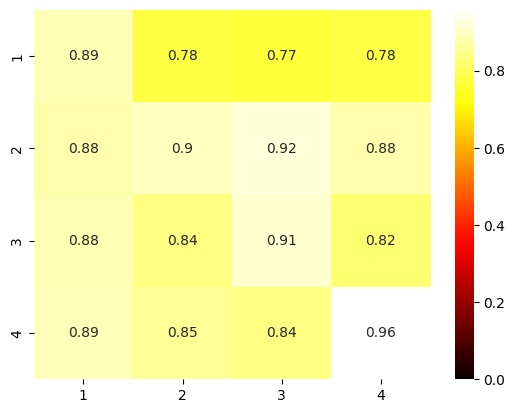

In [27]:
run_and_plot_transf("MNIST", 0.5)

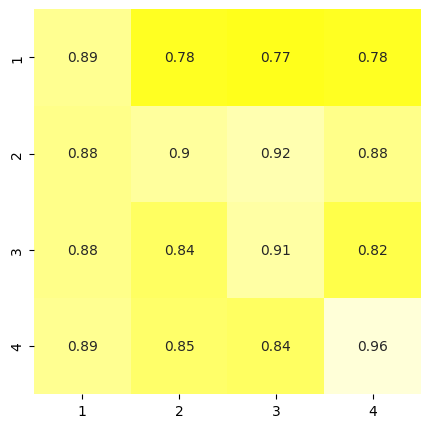

In [5]:
scores = [[0.89, 0.78, 0.77, 0.78],
          [0.88, 0.9, 0.92, 0.88],
          [0.88, 0.84, 0.91, 0.82],
          [0.89, 0.85, 0.84, 0.96]]
xs = [1, 2, 3, 4]
plt.figure(figsize=(5, 5))
sns.heatmap(scores, cmap="hot", annot=True, vmin=0, vmax=1, xticklabels=xs, yticklabels=xs, cbar=False)
# plt.savefig(f"{FILEPATH}/saved_transferability/transf_MNIST_05_v2.pdf", bbox_inches="tight")
plt.show()


training models...
getting images...
computing scores...
plotting results...


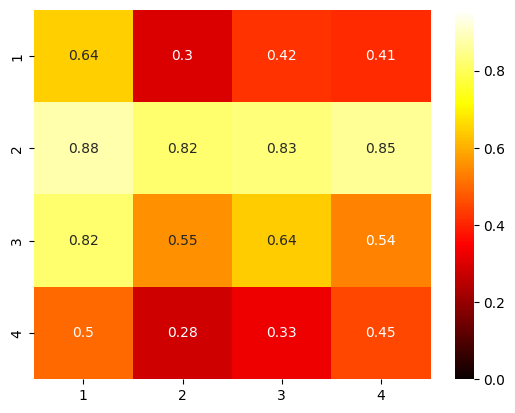

In [28]:
run_and_plot_transf("MNIST", 0.2)

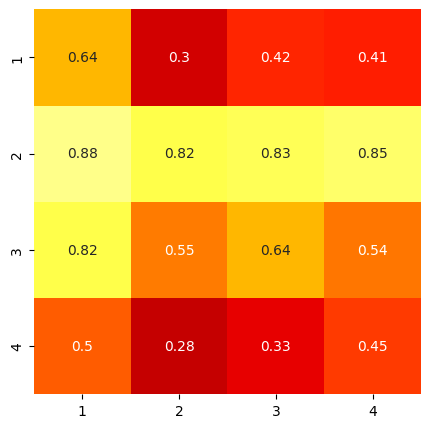

In [8]:
scores = [[0.64, 0.3, 0.42, 0.41],
          [0.88, 0.82, 0.83, 0.85],
          [0.82, 0.55, 0.64, 0.54],
          [0.5, 0.28, 0.33, 0.45]]
xs = [1, 2, 3, 4]
plt.figure(figsize=(5, 5))
sns.heatmap(scores, cmap="hot", annot=True, vmin=0, vmax=1, xticklabels=xs, yticklabels=xs, cbar=False)
plt.savefig(f"{FILEPATH}/saved_transferability/transf_MNIST_02_v2.pdf", bbox_inches="tight")
plt.show()

training models...
getting images...
computing scores...
plotting results...


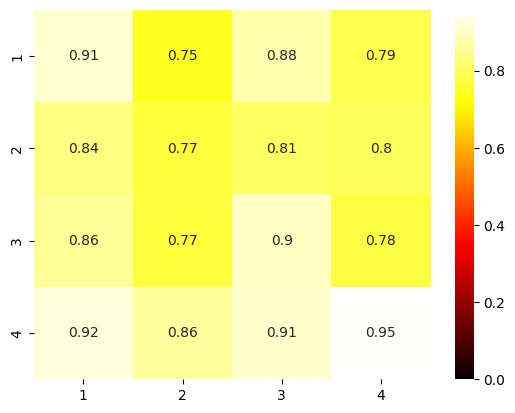

In [29]:
run_and_plot_transf("Fashion", 0.5)

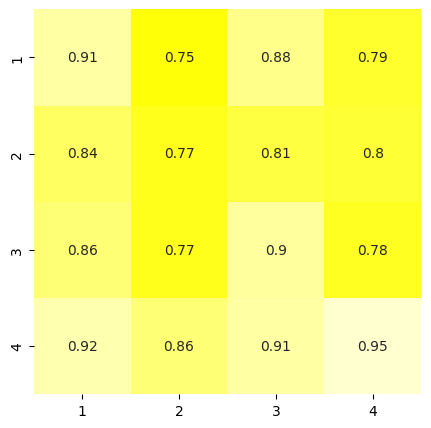

In [10]:
scores = [[0.91, 0.75, 0.88, 0.79],
          [0.84, 0.77, 0.81, 0.8],
          [0.86, 0.77, 0.9, 0.78],
          [0.92, 0.86, 0.91, 0.95]]
xs = [1, 2, 3, 4]
plt.figure(figsize=(5, 5))
sns.heatmap(scores, cmap="hot", annot=True, vmin=0, vmax=1, xticklabels=xs, yticklabels=xs, cbar=False)
plt.savefig(f"{FILEPATH}/saved_transferability/transf_Fashion_05_v2.pdf", bbox_inches="tight")
plt.show()

training models...
getting images...
computing scores...
plotting results...


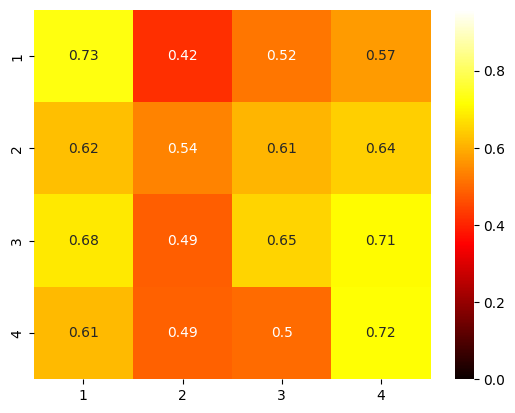

In [30]:
run_and_plot_transf("Fashion", 0.2)

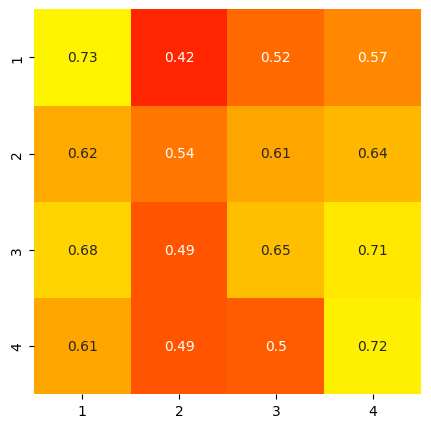

In [11]:
scores = [[0.73, 0.42, 0.52, 0.57],
          [0.62, 0.54, 0.61, 0.64],
          [0.68, 0.49, 0.65, 0.71],
          [0.61, 0.49, 0.5, 0.72]]
xs = [1, 2, 3, 4]
plt.figure(figsize=(5, 5))
sns.heatmap(scores, cmap="hot", annot=True, vmin=0, vmax=1, xticklabels=xs, yticklabels=xs, cbar=False)
plt.savefig(f"{FILEPATH}/saved_transferability/transf_Fashion_02_v2.pdf", bbox_inches="tight")
plt.show()

training models...
getting images...
computing scores...
plotting results...


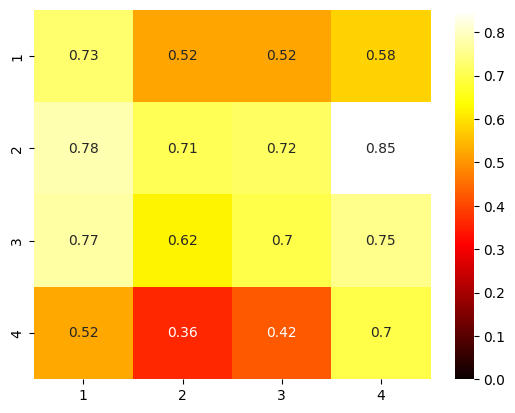

In [5]:
run_and_plot_transf("CIFAR10", 0.1)

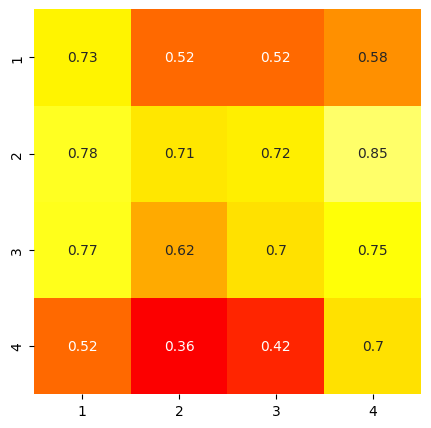

In [12]:
scores = [[0.73, 0.52, 0.52, 0.58],
          [0.78, 0.71, 0.72, 0.85],
          [0.77, 0.62, 0.7, 0.75],
          [0.52, 0.36, 0.42, 0.7]]
xs = [1, 2, 3, 4]
plt.figure(figsize=(5, 5))
sns.heatmap(scores, cmap="hot", annot=True, vmin=0, vmax=1, xticklabels=xs, yticklabels=xs, cbar=False)
plt.savefig(f"{FILEPATH}/saved_transferability/transf_CIFAR10_01_v2.pdf", bbox_inches="tight")
plt.show()

## DATA CHECK

In [71]:
with open(f"{FILEPATH}/saved_generated_data/gendata_5000_eps0.1_mS1_cifar_fixed.pickle", "rb") as file:
    d = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/saved_idxs_set_5000_0.1_mS1_cifar.pickle", "rb") as file:
    idxs = pickle.load(file)

# with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.5_mS1_fashion_TEST_fixed.pickle", "rb") as file:
#     d2 = pickle.load(file)

In [2]:
# load MNIST dataset

train_set, test_set = load_data("MNIST")
train_fash, test_fash = load_data("Fashion")
train_cif, test_cif = load_data("CIFAR10")


In [14]:

def plot_sample_img(classes, imgs, fname):
    counts = {}
    for i in range(10):
        counts[i] = 0

    fig = plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0, hspace=0)

    rows = columns = 10

    idx = 0
    while min(counts.values()) != 10:
        img, label = imgs[idx]
        if counts[label] != 10:
            fig.add_subplot(rows, columns, label*rows + counts[label] + 1)

            # plt.imshow(img.squeeze(), cmap="gray_r")
            plt.imshow(np.transpose(img, (1, 2, 0)), interpolation="nearest")
            plt.xticks([])
            plt.yticks([])

            if counts[label] == 0:
                # plt.ylabel(classes[label])
                plt.ylabel(classes[label], rotation=90)

            counts[label] += 1

        idx += 1

    # plt.savefig(f"{FILEPATH}/saved_imgs_datasets/{fname}", bbox_inches="tight")
    plt.savefig(f"{FILEPATH}/saved_imgs_thesis/appendix/{fname}", bbox_inches="tight")
    plt.show()


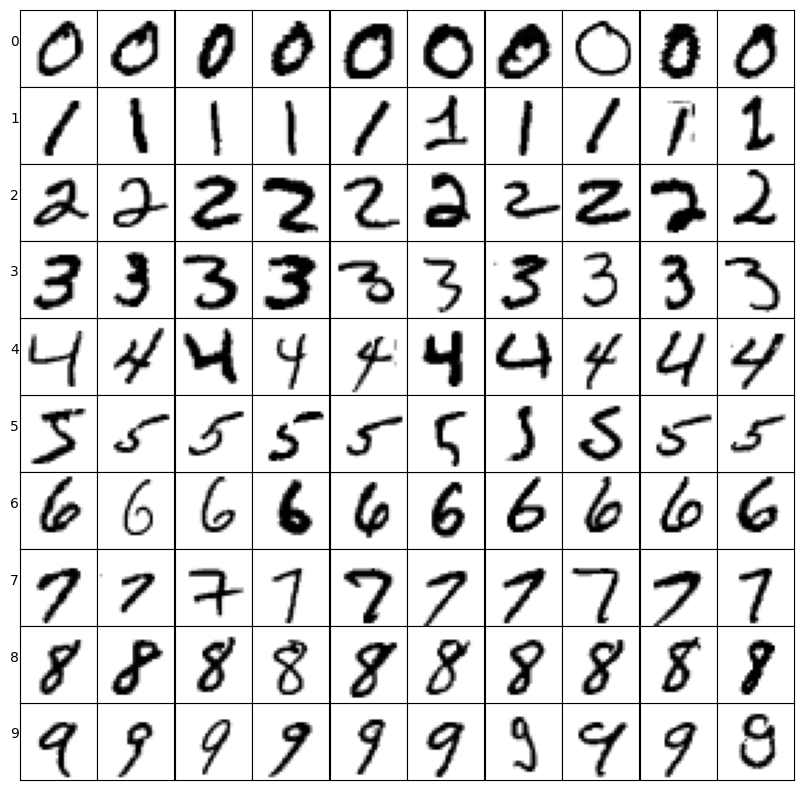

In [36]:
plot_sample_img(get_classes("MNIST"), train_set, "sample_mnist.pdf")

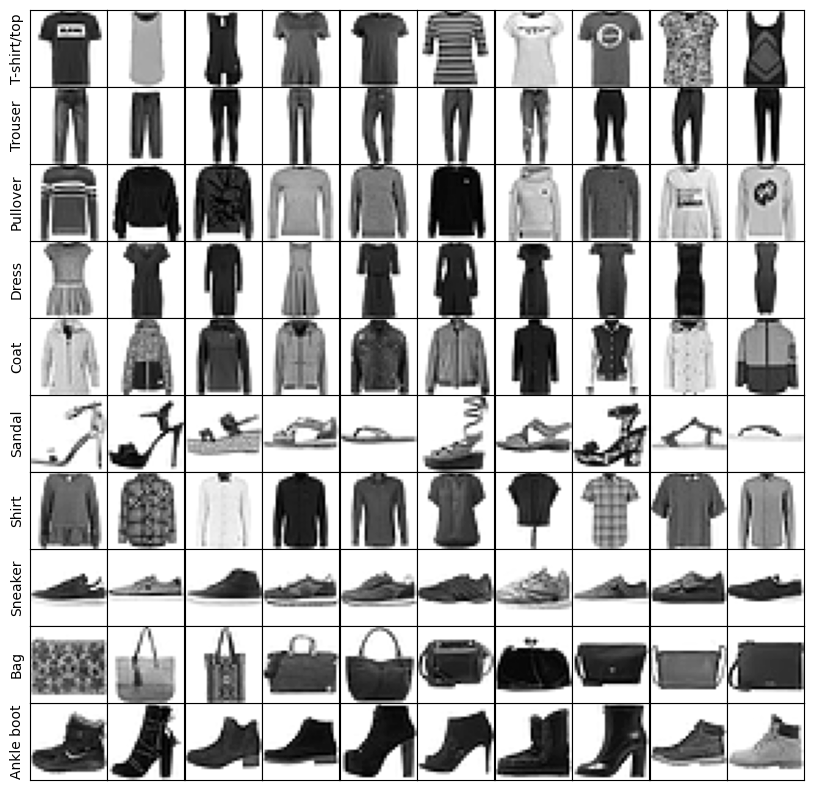

In [31]:
plot_sample_img(get_classes("Fashion"), train_fash, "sample_fashion.pdf")

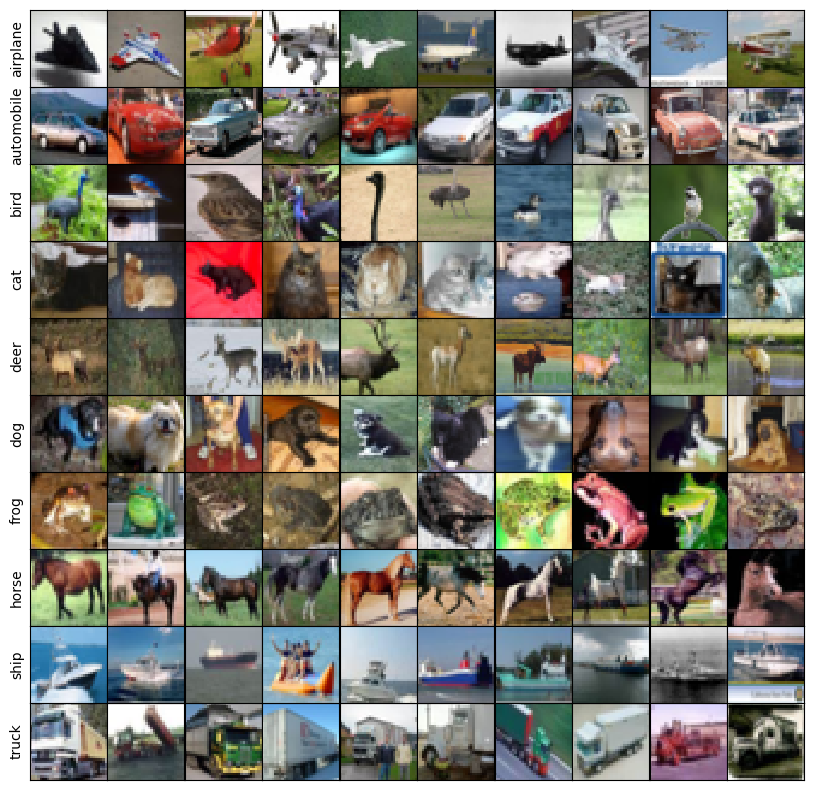

In [33]:
plot_sample_img(get_classes("CIFAR10"), train_cif, "sample_cifar.pdf")

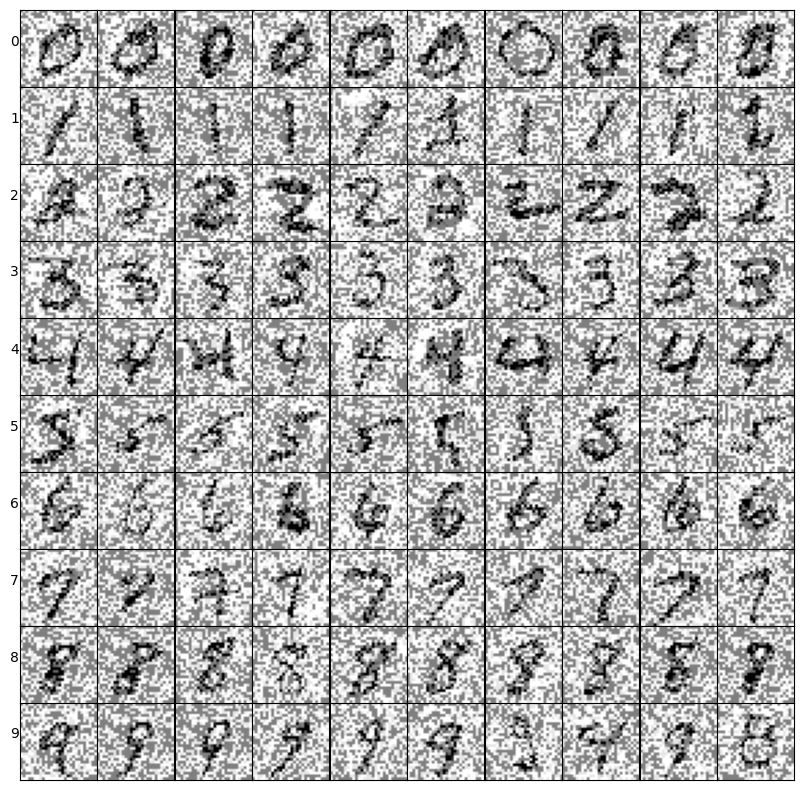

In [7]:
with open(f"{FILEPATH}/saved_generated_data/gendata_60000_eps0.5_mS1_mnist_fixed.pickle", "rb") as file:
    d = pickle.load(file)

plot_sample_img(get_classes("MNIST"), d, "adv_sample_mnist.pdf")



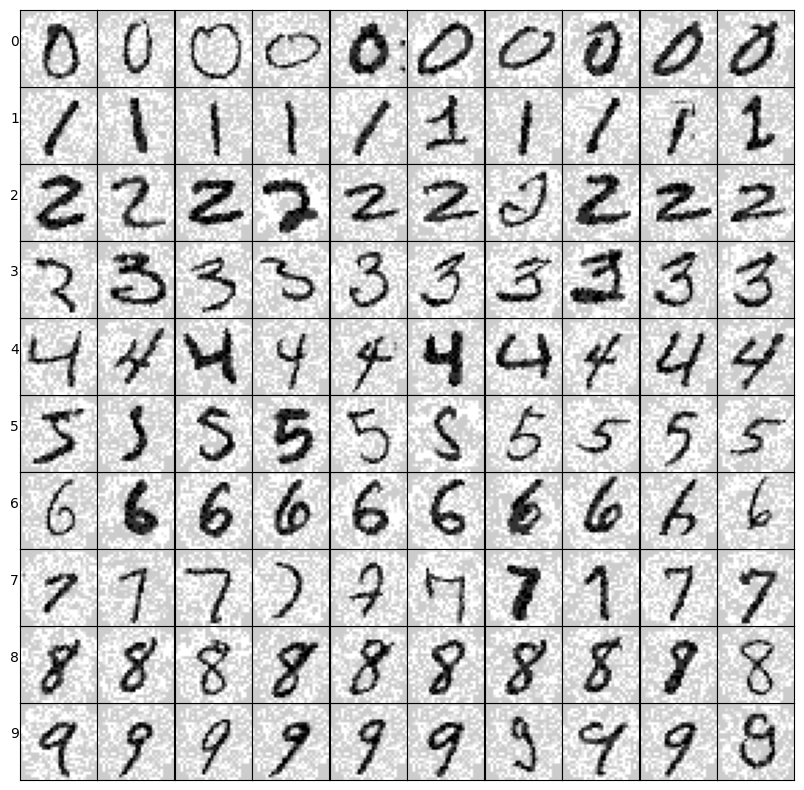

In [8]:
with open(f"{FILEPATH}/saved_generated_data/gendata_40000_eps0.2_mS1_mnist_fixed.pickle", "rb") as file:
    d = pickle.load(file)

plot_sample_img(get_classes("MNIST"), d, "adv_sample_mnist_02.pdf")

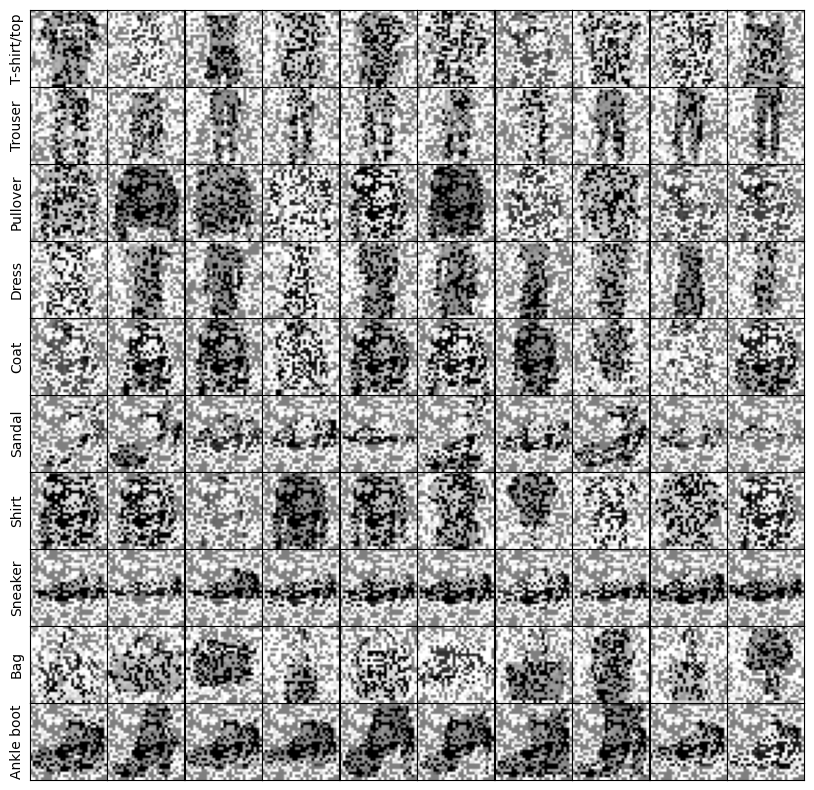

In [12]:
with open(f"{FILEPATH}/saved_generated_data/gendata_15000_eps0.5_mS1_fashion_fixed.pickle", "rb") as file:
    d = pickle.load(file)

plot_sample_img(get_classes("Fashion"), d, "adv_sample_fashion_05.pdf")

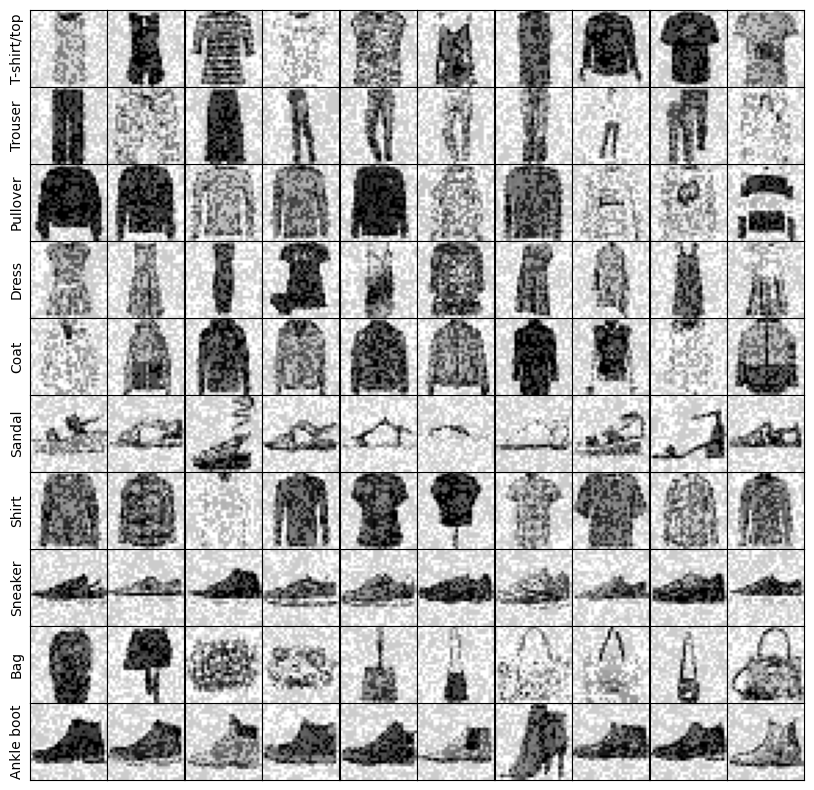

In [13]:
with open(f"{FILEPATH}/saved_generated_data/gendata_20000_eps0.2_mS1_fashion_fixed.pickle", "rb") as file:
    d = pickle.load(file)

plot_sample_img(get_classes("Fashion"), d, "adv_sample_fashion_02.pdf")

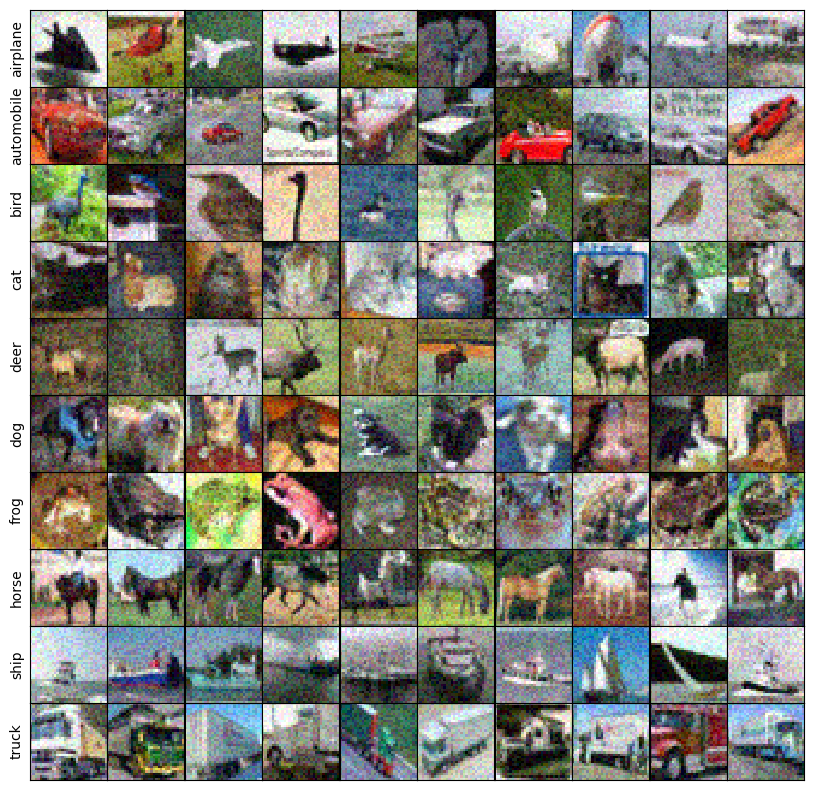

In [15]:
with open(f"{FILEPATH}/saved_generated_data/gendata_15000_eps0.1_mS1_cifar_fixed.pickle", "rb") as file:
    d = pickle.load(file)

plot_sample_img(get_classes("CIFAR10"), d, "adv_sample_cifar.pdf")

In [31]:
with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.2_mS1_fashion_TEST_fixed.pickle", "rb") as file:
    d = pickle.load(file)

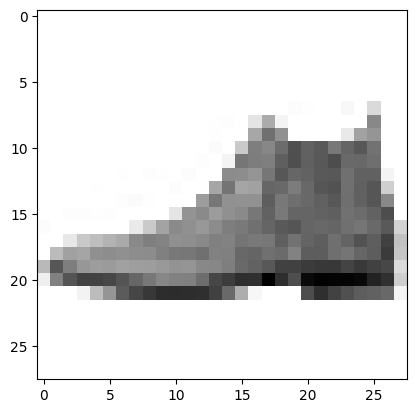

In [30]:
plt.imshow(test_fash[0][0].squeeze(), cmap="gray_r")
plt.show()

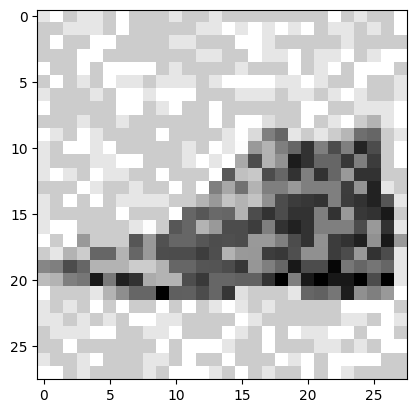

In [32]:
plt.imshow(d[0][0].squeeze(), cmap='gray_r')
plt.show()

In [11]:
model = Model2(3*32*32, 10)
train_d = DataLoader(train_cif, batch_size=64)
test_d = DataLoader(test_cif, batch_size=64)
model = train_test_model(model, train_d, test_d, epochs=5, save=False, verbose=False)

In [12]:
im, _ = generate_set_images("CIFAR10", 0.05, [0], model)

usage: ipykernel_launcher.py [-h] [--show-adv] [--batchsize BATCHSIZE]
                             [--workers WORKERS] [--data DATA] [--check-cvt]
                             [--no-attack]
                             [--sat-solver {z3,pysat,roundingsat,pysat_stat}]
                             [--pysat-name PYSAT_NAME]
                             [--write-formula WRITE_FORMULA]
                             [--write-slow-formula WRITE_SLOW_FORMULA]
                             [--write-result WRITE_RESULT]
                             [--write-adv WRITE_ADV] [-v VERBOSITY]
                             [-t TIMEOUT] [--skip SKIP]
                             [--num-cases NUM_CASES]
                             [--var-preference {z,z-ent,mid-first,first,first-sp,none}]
                             [--continue] [--random-sample RANDOM_SAMPLE]
                             [--log-file LOG_FILE] [--ensemble ENSEMBLE]
                             [--disable-model-cache]
                    

SystemExit: 2

/home/ben/Documents/Masters_thesis/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


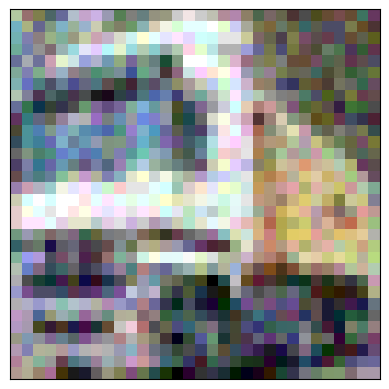

In [8]:
with open(f"{FILEPATH}/saved_generated_data/gendata_5000_eps0.1_mS1_cifar_fixed.pickle", "rb") as file:
    d = pickle.load(file)

plt.imshow(np.transpose(d[1][0], (1, 2, 0)), interpolation="nearest")
plt.xticks([])
plt.yticks([])

# plt.savefig(f"{FILEPATH}/saved_imgs_thesis/cifar_5_adv.pdf", bbox_inches="tight")

plt.show()

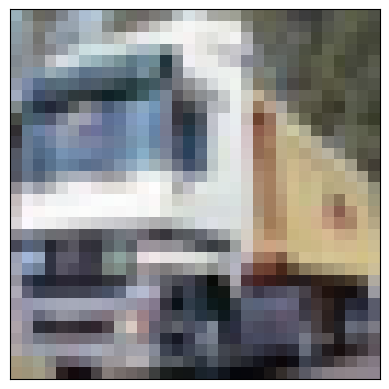

In [13]:
plt.imshow(np.transpose(train_cif[1][0], (1, 2, 0)), interpolation="nearest")
plt.xticks([])
plt.yticks([])
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/cifar_1.pdf", bbox_inches="tight")
plt.show()

## Classification graphs

In [2]:
def evaluate_robustness_acc_maj_classes(models, imgs, dataset_name="MNIST", with_uncertain=False):
    # same as original function but retrieve score for each class

    def get_majority_pred(lst):
        votes = {}
        for v in lst:
            if v in votes:
                votes[v] += 1
            else:
                votes[v] = 1
        return max(votes, key=votes.get)

    scores = np.zeros(10)
    sizes = np.zeros(10)
    classes = get_classes(dataset_name, with_uncertain=with_uncertain)

    with torch.no_grad():
        for img, true_label in imgs:
            all_preds = []
            for model in models:
                if dataset_name == "CIFAR10":
                    pred = model(img.reshape(1, 3, 32, 32))[0]
                else:
                    pred = model(img.reshape(1, 1, 28, 28))[0]
                pred = classes[pred.argmax(0)]
                all_preds.append(pred)
            pred = get_majority_pred(all_preds)

            if pred == classes[true_label]:
                lab = classes.index(pred)
                scores[lab] += 1
            
            sizes[true_label] += 1


    # get mean scores according to sizes
    for i in range(10):
        scores[i] /= sizes[i]

    return scores

In [3]:
with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.5_mS1_mnist_TEST_fixed.pickle", "rb") as file:
    mnist05_test = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.2_mS1_mnist_TEST_fixed.pickle", "rb") as file:
    mnist02_test = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.1_mS1_mnist_TEST_fixed.pickle", "rb") as file:
    mnist01_test = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.5_mS1_fashion_TEST_fixed.pickle", "rb") as file:
    fashion05_test = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.2_mS1_fashion_TEST_fixed.pickle", "rb") as file:
    fashion02_test = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.1_mS1_cifar_TEST_fixed.pickle", "rb") as file:
    cifar01_test = pickle.load(file)

In [36]:
models_notrain_mnist = []

for i in range(5):
    print(f"training model {i}...")
    model = Model1(28*28, 10, quant_value=0.1)

    train_set, test_set = load_data("MNIST")
    train_set = Data(train_set, limit=10000)
    train_data = DataLoader(train_set, batch_size=64)
    test_data = DataLoader(test_set, batch_size=64)

    train_test_model(model, train_data, test_data, epochs=25, save=False, verbose=False)
    models_notrain_mnist.append(model)
print('done')


training model 0...
training model 1...
training model 2...
training model 3...
training model 4...
done


In [38]:

# graph acc for models 1 MNIST eps 0.5

with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop4_models_mnist.pickle", "rb") as file:
    models_gen_mnist = pickle.load(file)

with open(f"{FILEPATH}/saved_graphs/23_2_models_mnist05.pickle", 'rb') as file:
    models_cheat_mnist = pickle.load(file)

scores_gen_mnist05     = evaluate_robustness_acc_maj_classes(models_gen_mnist,     mnist05_test, dataset_name="MNIST")
scores_cheat_mnist05   = evaluate_robustness_acc_maj_classes(models_cheat_mnist,   mnist05_test, dataset_name="MNIST")
scores_notrain_mnist05 = evaluate_robustness_acc_maj_classes(models_notrain_mnist, mnist05_test, dataset_name="MNIST")

scores_gen_mnist05 *= 100
scores_cheat_mnist05 *= 100
scores_notrain_mnist05 *= 100


In [39]:
print(f"mean score gen      : {np.mean(scores_gen_mnist05)}")
print(f"mean score cheat    : {np.mean(scores_cheat_mnist05)}")
print(f"mean score no train : {np.mean(scores_notrain_mnist05)}")

mean score gen      : 76.97983671784411
mean score cheat    : 79.50730151233445
mean score no train : 20.417116449408397


In [ ]:
x = np.arange(0, 10, dtype=int)

fig = plt.figure(figsize=(18, 5))

plt.subplot(131)
plt.bar(x, scores_gen_mnist05)
plt.xticks(x)
plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("generation approach")

plt.subplot(132)
plt.bar(x, scores_cheat_mnist05)
plt.xticks(x)
plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("cheat approach")

plt.subplot(133)
plt.bar(x, scores_notrain_mnist05)
plt.xticks(x)
plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("no adversarial training")

plt.savefig(f"{FILEPATH}/saved_graphs/classifications_mnist05.pdf")

plt.show()

In [4]:
# plot the graphs but with same y axis

gen_values = [82, 85, 68, 66, 81, 59, 72, 80, 78, 72]
cheat_values = [88, 95, 78, 77, 85, 68, 79, 80, 72, 71]
notrain_values = [8, 0, 40, 52, 0, 30, 32, 28, 6, 12]

x = np.arange(0, 10, dtype=int)
y = np.arange(0, 101, 10, dtype=int)

# fig = plt.figure(figsize=(18, 5))

# plt.subplot(131)
plt.bar(x, gen_values)
plt.xticks(x)
plt.yticks(y)
plt.xlabel("labels")
plt.ylabel("accuracy [%]")
# plt.title("generation approach")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/classifications_mnist05_gen.pdf")
plt.close()

# plt.subplot(132)
plt.bar(x, cheat_values)
plt.xticks(x)
plt.yticks(y)
plt.xlabel("labels")
plt.ylabel("accuracy [%]")
# plt.title("cheat approach")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/classifications_mnist05_cheat.pdf")
plt.close()

# plt.subplot(133)
plt.bar(x, notrain_values)
plt.xticks(x)
plt.yticks(y)
plt.xlabel("labels")
plt.ylabel("accuracy [%]")
# plt.title("no adversarial training")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/classifications_mnist05_noadv.pdf")
plt.close()

# plt.savefig(f"{FILEPATH}/saved_graphs/classifications_mnist05_v2.pdf")

# plt.show()


In [49]:
models_notrain_fashion = []

for i in range(5):
    print(f"training model {i}...")
    model = Model1(28*28, 10, quant_value=0.1)

    train_set, test_set = load_data("Fashion")
    train_set = Data(train_set, limit=10000)
    train_data = DataLoader(train_set, batch_size=64)
    test_data = DataLoader(test_set, batch_size=64)

    train_test_model(model, train_data, test_data, epochs=25, save=False, verbose=False)
    models_notrain_fashion.append(model)
print('done')

training model 0...
training model 1...
training model 2...
training model 3...
training model 4...
done


In [53]:

# graph acc for models 1 fashion 0.5

with open(f"{FILEPATH}/saved_graphs/27_models_fashion05.pickle", "rb") as file:
    models_gen_fashion = pickle.load(file)

with open(f"{FILEPATH}/saved_graphs/models_fashion05_cheat_2.pickle", 'rb') as file:
    models_cheat_fashion = pickle.load(file)

scores_gen_fashion05     = evaluate_robustness_acc_maj_classes(models_gen_fashion,     fashion05_test, dataset_name="Fashion")
scores_cheat_fashion05   = evaluate_robustness_acc_maj_classes(models_cheat_fashion,   fashion05_test, dataset_name="Fashion")
scores_notrain_fashion05 = evaluate_robustness_acc_maj_classes(models_notrain_fashion, fashion05_test, dataset_name="Fashion")

scores_gen_fashion05 *= 100
scores_cheat_fashion05 *= 100
scores_notrain_fashion05 *= 100

In [54]:
print(f"mean score gen      : {np.mean(scores_gen_fashion05)}")
print(f"mean score cheat    : {np.mean(scores_cheat_fashion05)}")
print(f"mean score no train : {np.mean(scores_notrain_fashion05)}")

mean score gen      : 68.05923694779116
mean score cheat    : 69.61602409638554
mean score no train : 12.080642570281125


In [ ]:
x = np.arange(0, 10, dtype=int)

fig = plt.figure(figsize=(18, 5))

labs = get_classes("Fashion")

plt.subplot(131)
plt.bar(x, scores_gen_fashion05)
plt.xticks(x, labs, rotation=90)
# plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("generation approach")

plt.subplot(132)
plt.bar(x, scores_cheat_fashion05)
plt.xticks(x, labs, rotation=90)
# plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("cheat approach")

plt.subplot(133)
plt.bar(x, scores_notrain_fashion05)
plt.xticks(x, labs, rotation=90)
# plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("no adversarial training")

plt.savefig(f"{FILEPATH}/saved_graphs/classifications_fashion05.pdf", bbox_inches="tight")

plt.show()

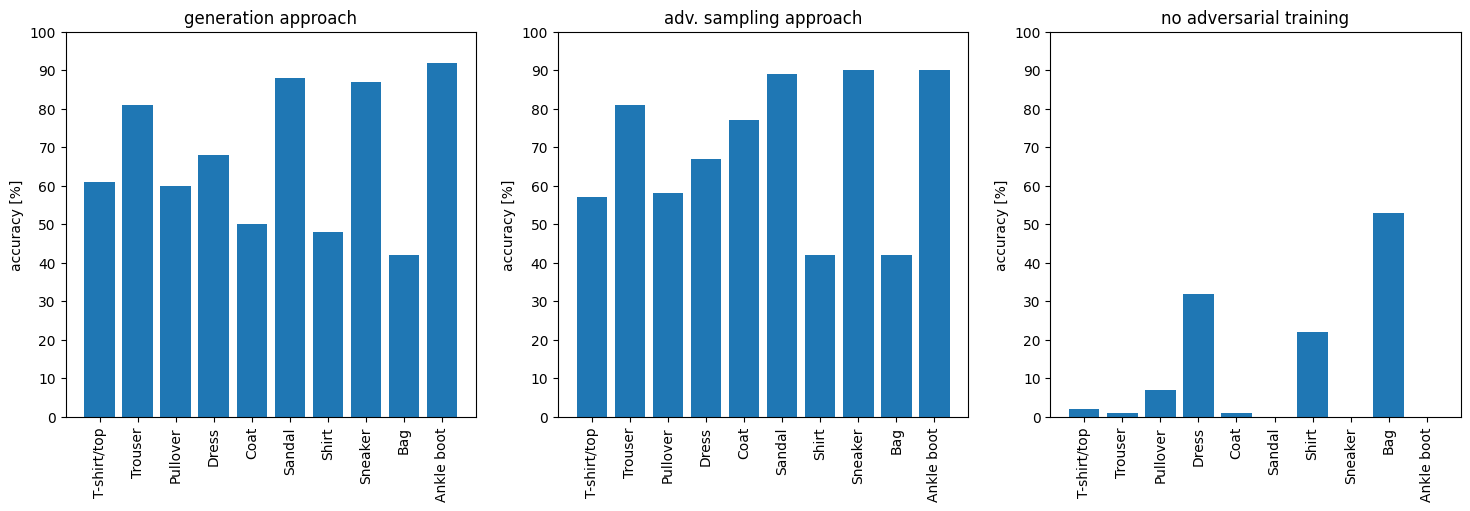

In [12]:

# re do with same y axis

gen_values = [61, 81, 60, 68, 50, 88, 48, 87, 42, 92]
cheat_values = [57, 81, 58, 67, 77, 89, 42, 90, 42, 90]
notrain_values = [2, 1, 7, 32, 1, 0, 22, 0, 53, 0]

x = np.arange(0, 10, dtype=int)
y = np.arange(0, 101, 10, dtype=int)

fig = plt.figure(figsize=(18, 5))

labs = get_classes("Fashion")

plt.subplot(131)
plt.bar(x, gen_values)
plt.xticks(x, labs, rotation=90)
plt.yticks(y)
# plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("generation approach")

plt.subplot(132)
plt.bar(x, cheat_values)
plt.xticks(x, labs, rotation=90)
plt.yticks(y)
# plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("adv. sampling approach")

plt.subplot(133)
plt.bar(x, notrain_values)
plt.xticks(x, labs, rotation=90)
plt.yticks(y)
# plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("no adversarial training")

plt.savefig(f"{FILEPATH}/saved_graphs/classifications_fashion05_v2.pdf", bbox_inches="tight")

plt.show()


In [4]:

# classification with cifar10

with open(f"{FILEPATH}/saved_models_eevbnn/model1_cifar_epoch25_maj.pickle", "rb") as file:
    models_notrain_cifar = pickle.load(file)

with open(f"{FILEPATH}/saved_graphs/29_models_gen_cifar01.pickle", "rb") as file:
    models_gen_cifar = pickle.load(file)

with open(f"{FILEPATH}/saved_graphs/31_models_cifar01.pickle", "rb") as file:
    models_cheat_cifar = pickle.load(file)

scores_gen_cifar     = evaluate_robustness_acc_maj_classes(models_gen_cifar,     cifar01_test, dataset_name="CIFAR10")
scores_cheat_cifar   = evaluate_robustness_acc_maj_classes(models_cheat_cifar,   cifar01_test, dataset_name="CIFAR10")
scores_notrain_cifar = evaluate_robustness_acc_maj_classes(models_notrain_cifar, cifar01_test, dataset_name="CIFAR10")

scores_gen_cifar *= 100
scores_cheat_cifar *= 100
scores_notrain_cifar *= 100




In [8]:
print(f"mean score gen      : {np.mean(scores_gen_cifar)}")
print(f"mean score cheat    : {np.mean(scores_cheat_cifar)}")
print(f"mean score no train : {np.mean(scores_notrain_cifar)}")

mean score gen      : 22.364357067218524
mean score cheat    : 24.843443912240538
mean score no train : 17.47515318328194


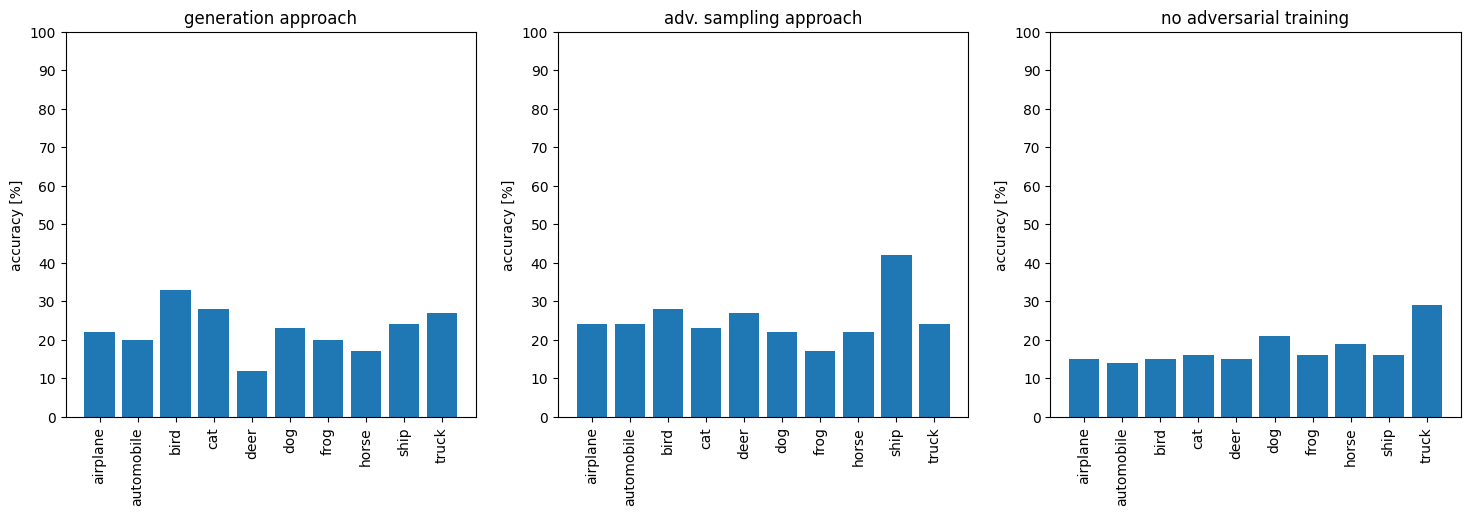

In [2]:
x = np.arange(0, 10, dtype=int)
y = np.arange(0, 101, 10, dtype=int)

scores_gen_cifar = [22, 20, 33, 28, 12, 23, 20, 17, 24, 27]
scores_cheat_cifar = [24, 24, 28, 23, 27, 22, 17, 22, 42, 24]
scores_notrain_cifar = [15, 14, 15, 16, 15, 21, 16, 19, 16, 29]

fig = plt.figure(figsize=(18, 5))

labs = get_classes("CIFAR10")

plt.subplot(131)
plt.bar(x, scores_gen_cifar)
plt.xticks(x, labs, rotation=90)
plt.yticks(y)
# plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("generation approach")

plt.subplot(132)
plt.bar(x, scores_cheat_cifar)
plt.xticks(x, labs, rotation=90)
plt.yticks(y)
# plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("adv. sampling approach")

plt.subplot(133)
plt.bar(x, scores_notrain_cifar)
plt.xticks(x, labs, rotation=90)
plt.yticks(y)
# plt.xlabel("labels")
plt.ylabel("accuracy [%]")
plt.title("no adversarial training")

plt.savefig(f"{FILEPATH}/saved_graphs/classifications_cifar01.pdf", bbox_inches="tight")

plt.show()

In [ ]:
# TODO same with models 4 on MNIST

## graphs

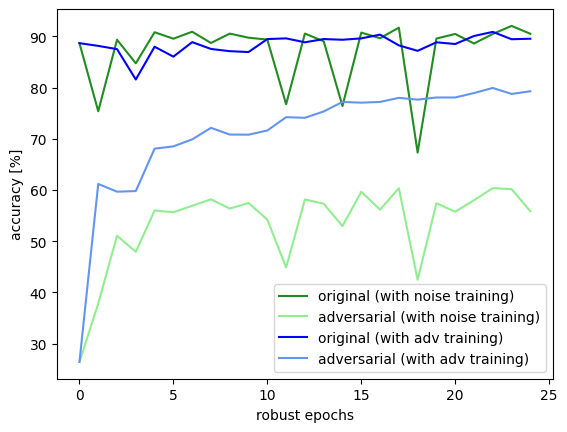

In [107]:
with open(f"{FILEPATH}/saved_graphs/01_robust_values_cheat_recreateTrue_mS5_epoch25_noise.pickle", "rb") as file:
    rob_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/01_test_values_cheat_recreateTrue_mS5_epoch25_noise.pickle", "rb") as file:
    test_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_robust_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    rob = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_test_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    tests = pickle.load(file)

x = np.arange(0, len(rob), dtype=int)
plt.xlabel("robust epochs")
plt.ylabel("accuracy [%]")

plt.plot(x, test_noise, "forestgreen", label="original (with noise training)")
plt.plot(x, rob_noise, "lightgreen", label="adversarial (with noise training)")
plt.plot(x, tests, "blue", label="original (with adv training)")
plt.plot(x, rob, "cornflowerblue", label="adversarial (with adv training)")

plt.legend()

plt.savefig(f"{FILEPATH}/saved_graphs/comp_adv_noise_training.pdf")

plt.show()

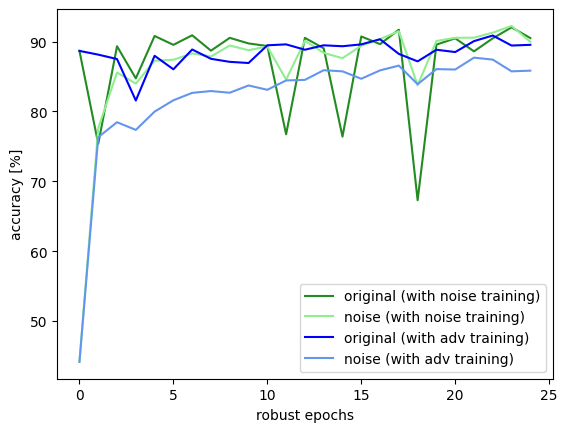

In [110]:
with open(f"{FILEPATH}/saved_graphs/03_robust_values_cheat_recreateTrue_mS5_epoch25_noisetest.pickle", "rb") as file:
    rob_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/03_test_values_cheat_recreateTrue_mS5_epoch25_noisetest.pickle", "rb") as file:
    test_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/04_robust_values_cheat_recreateTrue_mS5_epoch25_testNoise.pickle", "rb") as file:
    rob = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/04_test_values_cheat_recreateTrue_mS5_epoch25_testNoise.pickle", "rb") as file:
    tests = pickle.load(file)

x = np.arange(0, len(rob), dtype=int)
plt.xlabel("robust epochs")
plt.ylabel("accuracy [%]")

plt.plot(x, test_noise, "forestgreen", label="original (with noise training)")
plt.plot(x, rob_noise, "lightgreen", label="noise (with noise training)")
plt.plot(x, tests, "blue", label="original (with adv training)")
plt.plot(x, rob, "cornflowerblue", label="noise (with adv training)")

plt.legend()

plt.savefig(f"{FILEPATH}/saved_graphs/comp_adv_noise_training_testnoise.pdf")

plt.show()

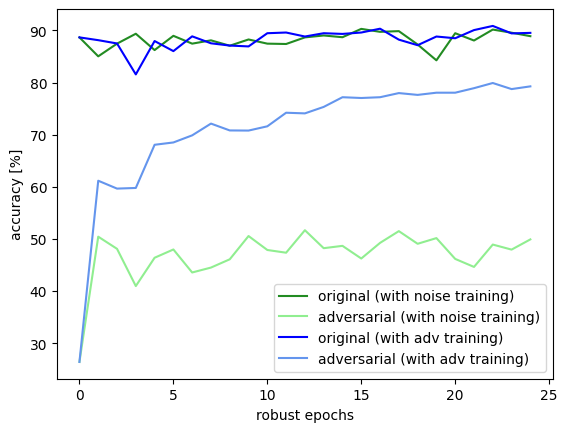

In [2]:
with open(f"{FILEPATH}/saved_graphs/05_robust_values_cheat_recreateTrue_mS5_epoch25_hnoise.pickle", "rb") as file:
    rob_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/05_test_values_cheat_recreateTrue_mS5_epoch25_hnoise.pickle", "rb") as file:
    test_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_robust_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    rob = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_test_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    tests = pickle.load(file)

x = np.arange(0, len(rob), dtype=int)
plt.xlabel("robust epochs")
plt.ylabel("accuracy [%]")

plt.plot(x, test_noise, "forestgreen", label="original (with noise training)")
plt.plot(x, rob_noise, "lightgreen", label="adversarial (with noise training)")
plt.plot(x, tests, "blue", label="original (with adv training)")
plt.plot(x, rob, "cornflowerblue", label="adversarial (with adv training)")

plt.legend()

plt.savefig(f"{FILEPATH}/saved_graphs/comp_adv_highnoise_training_testhighnoise.pdf")

plt.show()

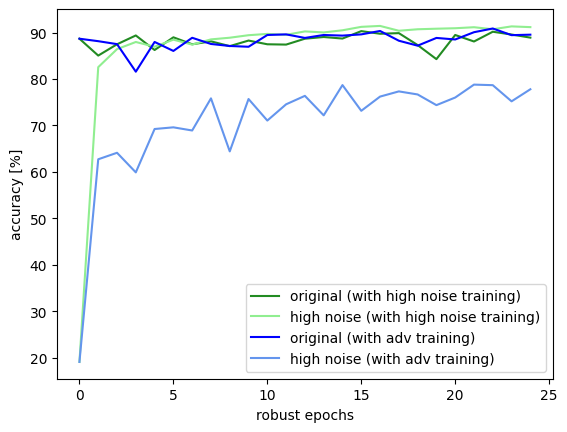

In [3]:
with open(f"{FILEPATH}/saved_graphs/06_robust_values_cheat_recreateTrue_mS5_epoch25_hnoise_hnoisetest.pickle", "rb") as file:
    rob_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/06_test_values_cheat_recreateTrue_mS5_epoch25_hnoise_hnoisetest.pickle", "rb") as file:
    test_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/07_robust_values_cheat_recreateTrue_mS5_epoch25_hnoisetest.pickle", "rb") as file:
    rob = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/07_test_values_cheat_recreateTrue_mS5_epoch25_hnoisetest.pickle", "rb") as file:
    tests = pickle.load(file)

x = np.arange(0, len(rob), dtype=int)
plt.xlabel("robust epochs")
plt.ylabel("accuracy [%]")

plt.plot(x, test_noise, "forestgreen", label="original (with high noise training)")
plt.plot(x, rob_noise, "lightgreen", label="high noise (with high noise training)")
plt.plot(x, tests, "blue", label="original (with adv training)")
plt.plot(x, rob, "cornflowerblue", label="high noise (with adv training)")

plt.legend()

plt.savefig(f"{FILEPATH}/saved_graphs/comp_adv_highnoise_training_testhighnoise.pdf")

plt.show()

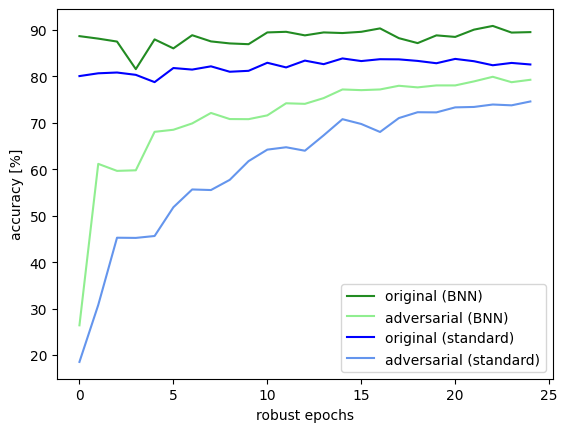

In [5]:
with open(f"{FILEPATH}/saved_graphs/02_robust_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    rob = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_test_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    tests = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/16_robust_values_standardModel.pickle", "rb") as file:
    rob_std = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/16_test_values_standardModel.pickle", "rb") as file:
    tests_std = pickle.load(file)

x = np.arange(0, len(rob), dtype=int)
plt.xlabel("robust epochs")
plt.ylabel("accuracy [%]")

plt.plot(x, tests, "forestgreen", label="original (BNN)")
plt.plot(x, rob, "lightgreen", label="adversarial (BNN)")
plt.plot(x, tests_std, "blue", label="original (standard)")
plt.plot(x, rob_std, "cornflowerblue", label="adversarial (standard)")

plt.legend()

plt.savefig(f"{FILEPATH}/saved_graphs/comp_adv_standard_BNN.pdf")

plt.show()




In [ ]:
with open(f"{FILEPATH}/saved_generated_data/gendata_40000_eps0.5_mS1_mnist_fixed.pickle", "rb") as file:
    d = pickle.load(file)

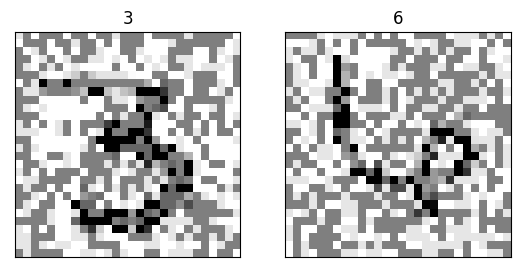

In [20]:
dtrain = d[:35000]
dtest = d[35000:]

i = 10

plt.subplot(121)
plt.title(dtrain[i][1])
plt.xticks([])
plt.yticks([])
plt.imshow(dtrain[i][0].squeeze(), cmap="gray_r")

plt.subplot(122)
plt.title(dtest[i][1])
plt.xticks([])
plt.yticks([])
plt.imshow(dtest[i][0].squeeze(), cmap="gray_r")

plt.show()


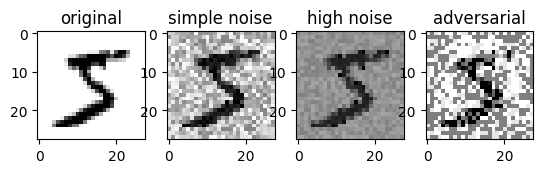

In [3]:
with open(f"{FILEPATH}/saved_generated_data/gendata_40000_eps0.5_noise.pickle", "rb") as file:
    d1 = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_40000_eps0.5_noiseHigh.pickle", "rb") as file:
    d2 = pickle.load(file)
    
with open(f"{FILEPATH}/saved_generated_data/gendata_40000_eps0.5_mS1_mnist_fixed.pickle", "rb") as file:
    d3 = pickle.load(file)

plt.subplot(141)
plt.title("original")
plt.imshow(train_set[0][0].squeeze(), cmap="gray_r")

plt.subplot(142)
plt.title("simple noise")
plt.imshow(d1[0][0].squeeze(), cmap="gray_r", vmin=0, vmax=1)

plt.subplot(143)
plt.title("high noise")
plt.imshow(d2[0][0].squeeze(), cmap="gray_r", vmin=0, vmax=1)

plt.subplot(144)
plt.title("adversarial")
plt.imshow(d3[0][0].squeeze(), cmap="gray_r", vmin=0, vmax=1)

plt.show()

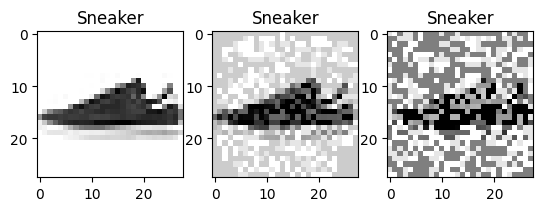

In [4]:
with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.5_mS1_fashion_fixed.pickle", "rb") as file:
    d = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.2_mS1_fashion_fixed.pickle", "rb") as file:
    d2 = pickle.load(file)

t, _ = load_data("Fashion")

i = 6
ori, lab = t[i]
im, label = d[i]
im2, label2 = d2[i]

classes = get_classes("Fashion")

plt.subplot(131)
plt.title(classes[lab])
plt.imshow(ori.squeeze(), cmap="gray_r")

plt.subplot(132)
plt.title(classes[label2])
plt.imshow(im2.squeeze(), cmap="gray_r")

plt.subplot(133)
plt.title(classes[label])
plt.imshow(im.squeeze(), cmap="gray_r")

plt.show()


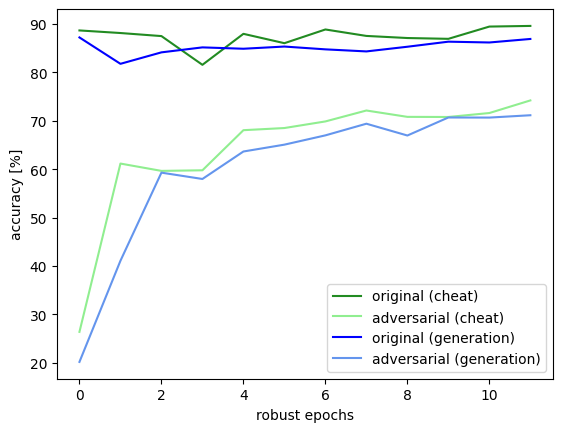

In [6]:
# graph comparison robust train loop vs robust train loop cheat

with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop_robustValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_robust_val = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop_accValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_test_val = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_robust_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    rob = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_test_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    tests = pickle.load(file)

n_robust_epoch = len(all_robust_val)

rob = rob[:n_robust_epoch]
tests = tests[:n_robust_epoch]
robloop_robust_val = []
robloop_test_val = []

for i in range(n_robust_epoch):
    r_val = np.mean(all_robust_val[i])
    t_val = np.mean(all_test_val[i])
    robloop_robust_val.append(r_val)
    robloop_test_val.append(t_val)

x = np.arange(0, n_robust_epoch, dtype=int)
plt.xlabel("robust epochs")
plt.ylabel("accuracy [%]")

plt.plot(x, tests, "forestgreen", label="original (cheat)")
plt.plot(x, rob, "lightgreen", label="adversarial (cheat)")
plt.plot(x, robloop_test_val, "blue", label="original (generation)")
plt.plot(x, robloop_robust_val, "cornflowerblue", label="adversarial (generation)")

plt.legend()

plt.savefig(f"{FILEPATH}/saved_graphs/comp_adv_robustLoop_cheat_generation.pdf")

plt.show()

gen_time = [9347.93, 12869.906, 19393.727, 18564.058, 19956.164, 22066.247, 18918.771, 22356.914, 21249.9, 24477.353, 26043.371]



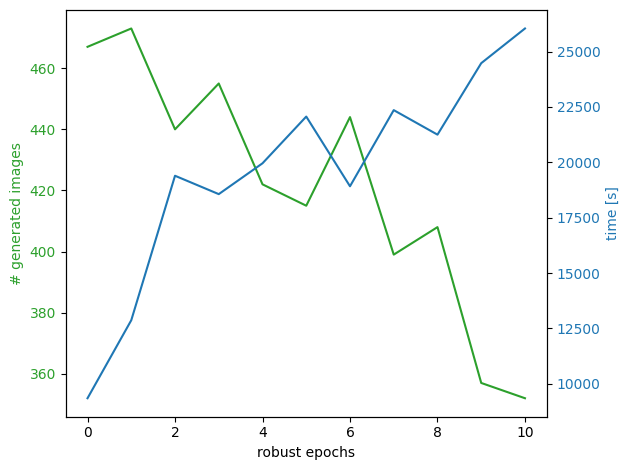

In [16]:
gen_time = [9347.93, 12869.906, 19393.727, 18564.058, 19956.164, 22066.247, 18918.771, 22356.914, 21249.9, 24477.353, 26043.371]

with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop_eps0.5_mnist_5models.pickle", "rb") as file:
    rl_imgs = pickle.load(file)

size_gen = []
for lst in rl_imgs:
    size_gen.append(len(lst))


fig, ax1 = plt.subplots()
x = np.arange(0, len(size_gen), dtype=int)

color = "tab:green"
ax1.set_xlabel("robust epochs")
ax1.set_ylabel("# generated images", color=color)
ax1.plot(x, size_gen, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel("time [s]", color=color)
ax2.plot(x, gen_time, color=color)
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()

plt.savefig(f"{FILEPATH}/saved_graphs/comp_robustLoop_time_ngeneration.pdf")

plt.show()




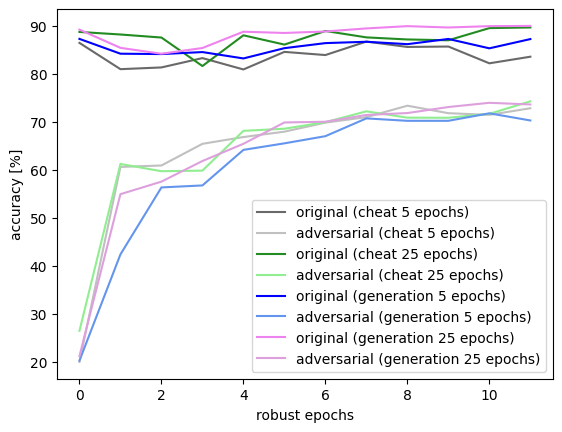

In [8]:
# graph comparison robust train loop vs robust train loop cheat

with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop_robustValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_robust_val = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop_accValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_test_val = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_robust_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    rob = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_test_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    tests = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/tmp_robs.pickle", "rb") as file:
    robs = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/tmp_accs.pickle", "rb") as file:
    accs = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop2_robustValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_robust_val2 = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop2_accValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_test_val2 = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop3_robustValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_robust_val3 = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop3_accValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_test_val3 = pickle.load(file)

n_robust_epoch = len(all_robust_val)

rob = rob[:n_robust_epoch]
tests = tests[:n_robust_epoch]
robloop_robust_val = []
robloop_test_val = []
robloop2_robust_val = []
robloop2_test_val = []
robloop3_robust_val = []
robloop3_test_val = []

r2 = []
a2 = []

for i in range(n_robust_epoch):
    r_val = np.mean(all_robust_val[i])
    t_val = np.mean(all_test_val[i])
    robloop_robust_val.append(r_val)
    robloop_test_val.append(t_val)

    robloop2_robust_val.append(np.mean(all_robust_val2[i]))
    robloop2_test_val.append(np.mean(all_test_val2[i]))

    robloop3_robust_val.append(np.mean(all_robust_val3[i]))
    robloop3_test_val.append(np.mean(all_test_val3[i]))

    r2.append(np.mean(robs[i]))
    a2.append(np.mean(accs[i]))



x = np.arange(0, n_robust_epoch, dtype=int)
plt.xlabel("robust epochs")
plt.ylabel("accuracy [%]")


# plt.plot(x, robloop_test_val, "blue", label="original (generation 5 epochs)")
# plt.plot(x, robloop_robust_val, "cornflowerblue", label="adversarial (generation 5 epochs)")
plt.plot(x, a2, "dimgrey", label="original (cheat 5 epochs)")
plt.plot(x, r2, "silver", label="adversarial (cheat 5 epochs)")
plt.plot(x, tests, "forestgreen", label="original (cheat 25 epochs)")
plt.plot(x, rob, "lightgreen", label="adversarial (cheat 25 epochs)")
plt.plot(x, robloop3_test_val, "blue", label="original (generation 5 epochs)")
plt.plot(x, robloop3_robust_val, "cornflowerblue", label="adversarial (generation 5 epochs)")
plt.plot(x, robloop2_test_val, "violet", label="original (generation 25 epochs)")
plt.plot(x, robloop2_robust_val, "plum", label="adversarial (generation 25 epochs)")


plt.legend()

plt.savefig(f"{FILEPATH}/saved_graphs/comp_adv_robustLoop_cheat_generation.pdf")

plt.show()

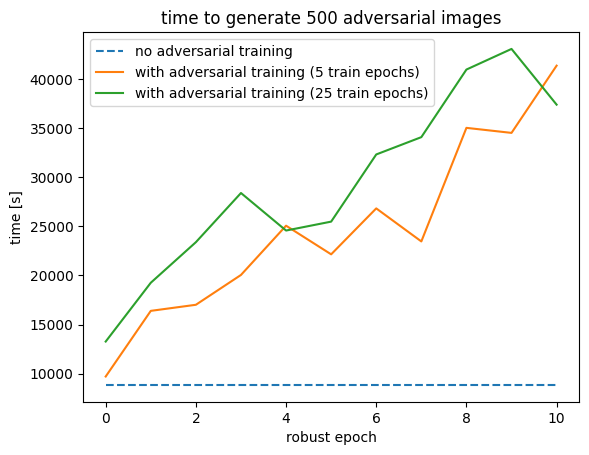

In [9]:
gen_times = [9716.213, 16395.349, 17014.546, 20049.684, 25060.577, 22147.055, 26820.963, 23459.128, 35014.881, 34503.159, 41342.859]

gen_times2 = [13274.027, 19255.770, 23383.343, 28386.383, 24567.158, 25474.849, 32308.677, 34070.458, 40947.119, 43046.286, 37376.165]


gen_cheat = 8860.155


x = np.arange(0, len(gen_times), dtype=int)
means = [gen_cheat for _ in range(len(x))]

plt.plot(x, means, "--", label="no adversarial training")
plt.plot(x, gen_times, label="with adversarial training (5 train epochs)")
plt.plot(x, gen_times2, label="with adversarial training (25 train epochs)")

plt.legend()
plt.xlabel("robust epoch")
plt.ylabel("time [s]")
plt.title("time to generate 500 adversarial images")

plt.savefig(f"{FILEPATH}/saved_graphs/comp_robustLoop_time_ngeneration.pdf")

plt.show()


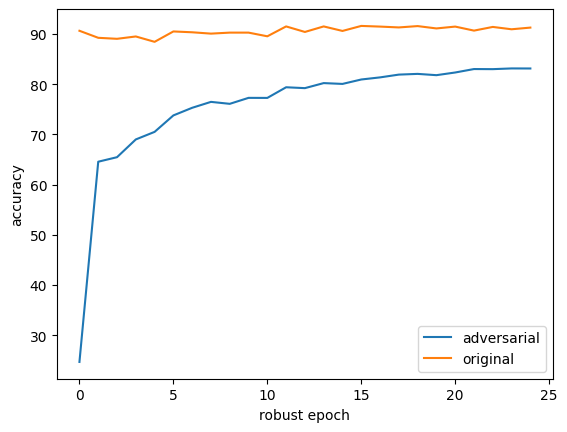

In [3]:
with open(f"{FILEPATH}/saved_graphs/23_robust_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    rob_maj = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/23_test_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    test_maj = pickle.load(file)

x = np.arange(0, len(rob_maj), dtype=int)
plt.plot(x, rob_maj, label="adversarial")
plt.plot(x, test_maj, label="original")
plt.xlabel("robust epoch")
plt.ylabel("accuracy")
plt.legend()

plt.savefig(f"{FILEPATH}/saved_graphs/23_robust_graph_epoch25_cheat_recreateTrue_mS5_majority.pdf")

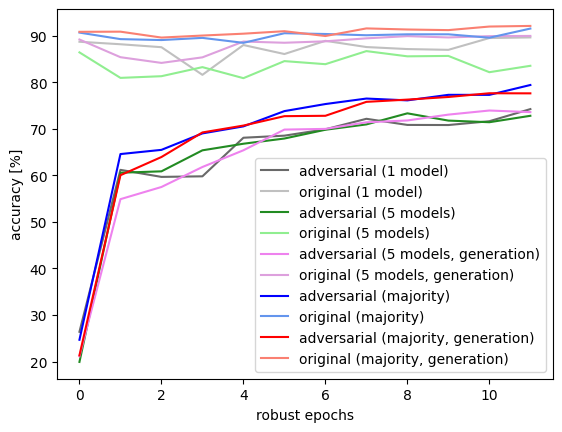

In [2]:
with open(f"{FILEPATH}/saved_graphs/23_robust_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    rob_maj = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/23_test_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    test_maj = pickle.load(file)

with open(f"{FILEPATH}/saved_graphs/02_robust_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    rob_simple = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_test_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    test_simple = pickle.load(file)

with open(f"{FILEPATH}/saved_graphs/tmp_robs.pickle", "rb") as file:
    rob_5_cheat_full = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/tmp_accs.pickle", "rb") as file:
    test_5_cheat_full = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop2_robustValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_robust_val2 = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop2_accValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_test_val2 = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop4_robustValues_eps0.5_mnist_5models.pickle", "rb") as file:
    rob_maj_loop = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop4_accValues_eps0.5_mnist_5models.pickle", "rb") as file:
    test_maj_loop = pickle.load(file)

rob_5_cheat = []
test_5_cheat = []

rob_loop = []
test_loop = []

n_robust_epoch = 12

for i in range(n_robust_epoch):
    rob_loop.append(np.mean(all_robust_val2[i]))
    test_loop.append(np.mean(all_test_val2[i]))
    rob_5_cheat.append(np.mean(rob_5_cheat_full[i]))
    test_5_cheat.append(np.mean(test_5_cheat_full[i]))


x = np.arange(0, n_robust_epoch, dtype=int)
plt.xlabel("robust epochs")
plt.ylabel("accuracy [%]")


# plt.plot(x, robloop_test_val, "blue", label="original (generation 5 epochs)")
# plt.plot(x, robloop_robust_val, "cornflowerblue", label="adversarial (generation 5 epochs)")
plt.plot(x, rob_simple[:n_robust_epoch], "dimgrey", label="adversarial (1 model)")
plt.plot(x, test_simple[:n_robust_epoch], "silver", label="original (1 model)")
plt.plot(x, rob_5_cheat[:n_robust_epoch], "forestgreen", label="adversarial (5 models)")
plt.plot(x, test_5_cheat[:n_robust_epoch], "lightgreen", label="original (5 models)")
plt.plot(x, rob_loop[:n_robust_epoch], "violet", label="adversarial (5 models, generation)")
plt.plot(x, test_loop[:n_robust_epoch], "plum", label="original (5 models, generation)")
plt.plot(x, rob_maj[:n_robust_epoch], "blue", label="adversarial (majority)")
plt.plot(x, test_maj[:n_robust_epoch], "cornflowerblue", label="original (majority)")
plt.plot(x, rob_maj_loop[:n_robust_epoch], "red", label="adversarial (majority, generation)")
plt.plot(x, test_maj_loop[:n_robust_epoch], "salmon", label="original (majority, generation)")

plt.legend()

plt.savefig(f"{FILEPATH}/saved_graphs/comp_adv_majority_all.pdf")

plt.show()





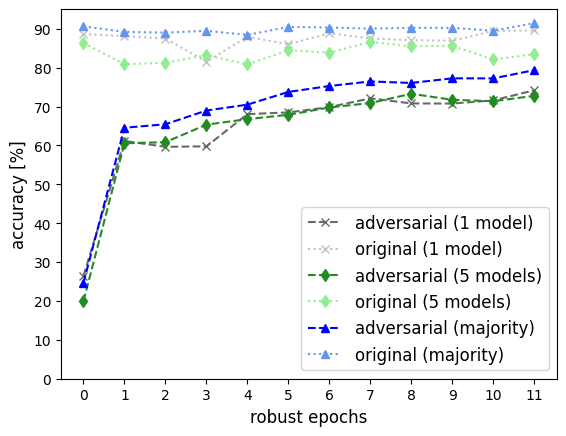

In [2]:
with open(f"{FILEPATH}/saved_graphs/23_robust_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    rob_maj = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/23_test_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    test_maj = pickle.load(file)

with open(f"{FILEPATH}/saved_graphs/02_robust_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    rob_simple = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/02_test_values_cheat_recreateTrue_mS5_epoch25.pickle", "rb") as file:
    test_simple = pickle.load(file)

with open(f"{FILEPATH}/saved_graphs/tmp_robs.pickle", "rb") as file:
    rob_5_cheat_full = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/tmp_accs.pickle", "rb") as file:
    test_5_cheat_full = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop2_robustValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_robust_val2 = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop2_accValues_eps0.5_mnist_5models.pickle", "rb") as file:
    all_test_val2 = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop4_robustValues_eps0.5_mnist_5models.pickle", "rb") as file:
    rob_maj_loop = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop4_accValues_eps0.5_mnist_5models.pickle", "rb") as file:
    test_maj_loop = pickle.load(file)

rob_5_cheat = []
test_5_cheat = []

rob_loop = []
test_loop = []

n_robust_epoch = 12

for i in range(n_robust_epoch):
    rob_loop.append(np.mean(all_robust_val2[i]))
    test_loop.append(np.mean(all_test_val2[i]))
    rob_5_cheat.append(np.mean(rob_5_cheat_full[i]))
    test_5_cheat.append(np.mean(test_5_cheat_full[i]))


x = np.arange(0, n_robust_epoch, dtype=int)
y = np.arange(0, 100, 10, dtype=int)
plt.xlabel("robust epochs", fontsize="large")
plt.ylabel("accuracy [%]", fontsize="large")

plt.xticks(x)

# plt.plot(x, robloop_test_val, "blue", label="original (generation 5 epochs)")
# plt.plot(x, robloop_robust_val, "cornflowerblue", label="adversarial (generation 5 epochs)")
plt.plot(x, rob_simple[:n_robust_epoch], "x--", color="dimgrey", label="adversarial (1 model)")
plt.plot(x, test_simple[:n_robust_epoch], "x:", color="silver", label="original (1 model)")
plt.plot(x, rob_5_cheat[:n_robust_epoch], "d--", color="forestgreen", label="adversarial (5 models)")
plt.plot(x, test_5_cheat[:n_robust_epoch], "d:", color="lightgreen", label="original (5 models)")
# plt.plot(x, rob_loop[:n_robust_epoch], "violet", label="adversarial (5 models, generation)")
# plt.plot(x, test_loop[:n_robust_epoch], "plum", label="original (5 models, generation)")
plt.plot(x, rob_maj[:n_robust_epoch], "^--", color="blue", label="adversarial (majority)")
plt.plot(x, test_maj[:n_robust_epoch], "^:", color="cornflowerblue", label="original (majority)")
# plt.plot(x, rob_maj_loop[:n_robust_epoch], "red", label="adversarial (majority, generation)")
# plt.plot(x, test_maj_loop[:n_robust_epoch], "salmon", label="original (majority, generation)")

plt.legend(fontsize="large")
plt.yticks(y)
# plt.savefig(f"{FILEPATH}/saved_imgs_thesis/comparison_models.pdf")

plt.show()

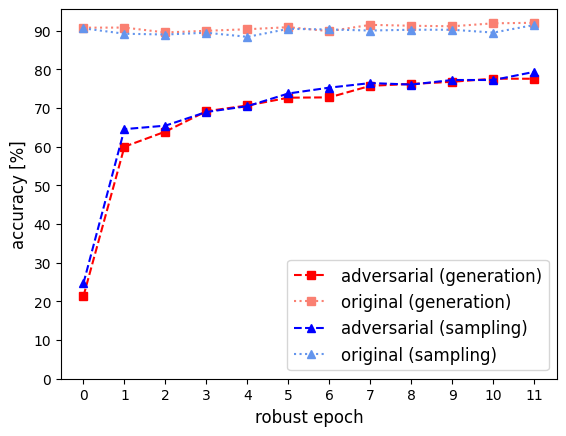

In [3]:
x = np.arange(0, n_robust_epoch, dtype=int)
y = np.arange(0, 100, 10, dtype=int)
plt.xlabel("robust epoch", fontsize="large")
plt.ylabel("accuracy [%]", fontsize="large")

plt.xticks(x)

plt.plot(x, rob_maj_loop[:n_robust_epoch], "s--", color="red", label="adversarial (generation)")
plt.plot(x, test_maj_loop[:n_robust_epoch], "s:", color="salmon", label="original (generation)")
plt.plot(x, rob_maj[:n_robust_epoch], "^--", color="blue", label="adversarial (sampling)")
plt.plot(x, test_maj[:n_robust_epoch], "^:", color="cornflowerblue", label="original (sampling)")

# plt.plot(x, rob_maj_loop[:n_robust_epoch], "s--", color="black", label="adversarial (generation)")
# plt.plot(x, test_maj_loop[:n_robust_epoch], "s:", color="black", label="original (generation)")
# plt.plot(x, rob_maj[:n_robust_epoch], "^--", color="black", label="adversarial (cheat)")
# plt.plot(x, test_maj[:n_robust_epoch], "^:", color="black", label="original (cheat)")

plt.legend(fontsize="large")
plt.yticks(y)
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/comparison_cheat_generation.pdf")

plt.show()

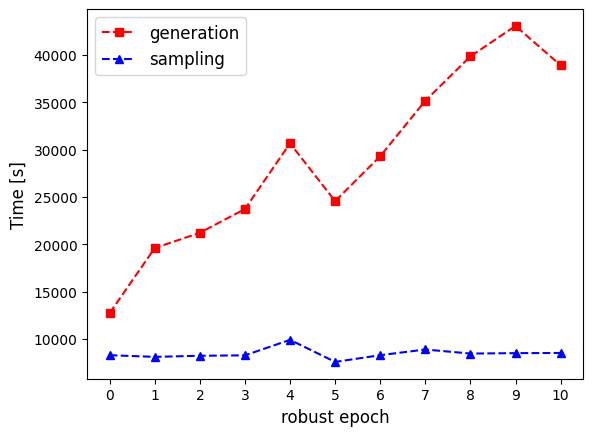

In [4]:
times_gen = [12740.914, 19608.022, 21222.49, 23736.265, 30668.876, 24564.014, 29312.231, 35164.794, 39855.747, 43072.068, 38913.449]

all_times_cheat = [8138.459, 16428.585, 24543.106, 32774.352, 41050.031, 50962.748, 58543.437, 66833.587, 75727.717, 84191.701, 92699.455, 101223.736]
times_cheat = []
# times_cheat.append(all_times_cheat[0])
for i in range(1, len(all_times_cheat)):
    times_cheat.append(all_times_cheat[i] - all_times_cheat[i-1])

x_time = np.arange(0, 11, dtype=int)

plt.plot(x_time, times_gen, "s--", color="red", label="generation")
plt.plot(x_time, times_cheat, "^--", color="blue", label="sampling")
plt.xlabel("robust epoch", fontsize="large")
plt.ylabel("Time [s]", fontsize="large")
plt.xticks(x_time)
plt.legend(fontsize="large")

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/comparison_cheat_generation_times.pdf")

plt.show()



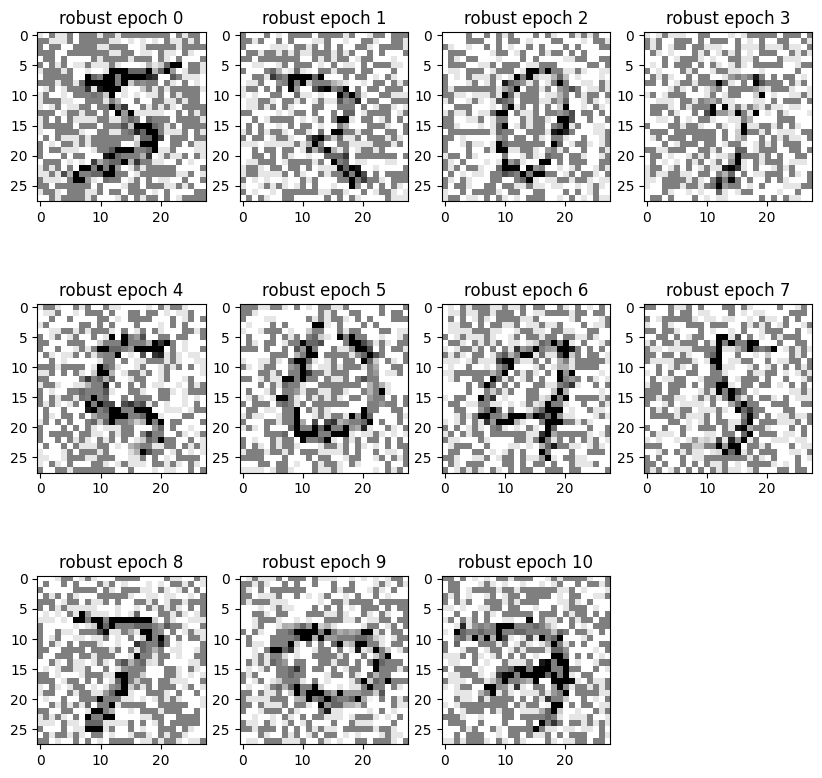

In [28]:

f = plt.figure(figsize=(10, 10))
for i in range(n_robust_epoch-1):
    f.add_subplot(3, 4, i+1)
    plt.imshow(rl_imgs[i][0][0].squeeze(), cmap="gray_r")
    plt.title(f"robust epoch {i}")

plt.show()

### validation with fashion and cifar

In [5]:

with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop4_robustValues_eps0.5_mnist_5models.pickle", "rb") as file:
    rob_mnist05_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_robustLoop4_accValues_eps0.5_mnist_5models.pickle", "rb") as file:
    test_mnist05_gen = pickle.load(file)


with open(f"{FILEPATH}/saved_graphs/23_robust_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    rob_mnist05 = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/23_test_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    test_mnist05 = pickle.load(file)


with open(f"{FILEPATH}/saved_graphs/24_robust_values_cheat_recreateTrue_mS5_epoch25_majority_fashion.pickle", "rb") as file:
    rob_fash05 = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/24_test_values_cheat_recreateTrue_mS5_epoch25_majority_fashion.pickle", "rb") as file:
    test_fash05 = pickle.load(file)


with open(f"{FILEPATH}/saved_graphs/25_robust_values_cheat_recreateTrue_mS5_epoch25_majority_mnist02.pickle", "rb") as file:
    rob_mnist02 = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/25_test_values_cheat_recreateTrue_mS5_epoch25_majority_mnist02.pickle", "rb") as file:
    test_mnist02 = pickle.load(file)


with open(f"{FILEPATH}/saved_graphs/27_robust_values_gen_recreateTrue_mS5_epoch25_majority_fashion05.pickle", "rb") as file:
    rob_fash05_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/27_test_values_gen_recreateTrue_mS5_epoch25_majority_fashion05.pickle", "rb") as file:
    test_fash05_gen = pickle.load(file)


with open(f"{FILEPATH}/saved_graphs/28_robust_values_gen_recreateTrue_mS5_epoch25_majority_fashion02.pickle", "rb") as file:
    rob_fash02_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/28_test_values_gen_recreateTrue_mS5_epoch25_majority_fashion02.pickle", "rb") as file:
    test_fash02_gen = pickle.load(file)
    
    
with open(f"{FILEPATH}/saved_graphs/29_robust_values_gen_recreateTrue_mS5_epoch25_majority_cifar01.pickle", "rb") as file:
    rob_cif01_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/29_test_values_gen_recreateTrue_mS5_epoch25_majority_cifar01.pickle", "rb") as file:
    test_cif01_gen = pickle.load(file) 
    

with open(f"{FILEPATH}/saved_graphs/30_robust_values_cheat_recreateTrue_mS5_epoch25_majority_fashion02.pickle", "rb") as file:
    rob_fash02 = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/30_test_values_cheat_recreateTrue_mS5_epoch25_majority_fashion02.pickle", "rb") as file:
    test_fash02 = pickle.load(file)


with open(f"{FILEPATH}/saved_graphs/31_robust_values_cheat_recreateTrue_mS5_epoch25_majority_cifar01.pickle", "rb") as file:
    rob_cif01 = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/31_test_values_cheat_recreateTrue_mS5_epoch25_majority_cifar01.pickle", "rb") as file:
    test_cif01 = pickle.load(file)


with open(f"{FILEPATH}/saved_graphs/34_robust_values_cheat_recreateTrue_mS5_t4_epoch25_majority_mnist05.pickle", "rb") as file:
    rob_mnist05_m4 = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/34_test_values_cheat_recreateTrue_mS5_t4_epoch25_majority_mnist05.pickle", "rb") as file:
    test_mnist05_m4 = pickle.load(file)



n_robust_epoch = 12

x = np.arange(0, n_robust_epoch, dtype=int)



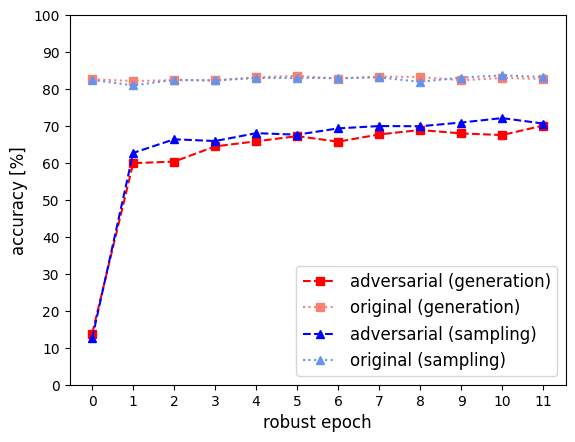

In [6]:

# comparison mnist - fashion with eps 0.5


n_robust_epoch = 12

x = np.arange(0, n_robust_epoch, dtype=int)
y = np.arange(0, 101, 10, dtype=int)

plt.figure(figsize=(18, 7))

# plt.subplot(121)
plt.plot(x, rob_mnist05[:n_robust_epoch],       "orange", label="adversarial (cheat)")
plt.plot(x, test_mnist05[:n_robust_epoch],      "bisque", label="original (cheat)")
plt.plot(x, rob_mnist05_gen[:n_robust_epoch],   "blue", label="adversarial (generation)")
plt.plot(x, test_mnist05_gen[:n_robust_epoch],  "lightblue", label="original (generation)")
plt.xlabel("robust epochs", fontsize="large")
plt.ylabel("accuracy", fontsize="large")
plt.legend()
plt.title("MNIST (eps 0.5)")
plt.close()

# plt.subplot(122)
plt.plot(x, rob_fash05_gen,  "s--", color="red", label="adversarial (generation)")
plt.plot(x, test_fash05_gen, "s:", color="salmon", label="original (generation)")
plt.plot(x, rob_fash05,      "^--", color="blue", label="adversarial (sampling)")
plt.plot(x, test_fash05,     "^:", color="cornflowerblue", label="original (sampling)")

plt.xlabel("robust epoch", fontsize="large")
plt.ylabel("accuracy [%]", fontsize="large")
plt.legend(fontsize="large")
plt.yticks(y)
plt.xticks(x)
# plt.title("Fashion (eps 0.5)")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/comparison_cheat_gen_fashion.pdf", bbox_inches="tight")

plt.show()



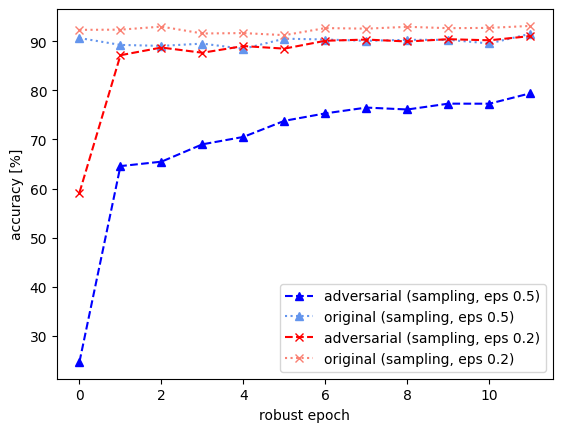

In [8]:
x = np.arange(0, 12, dtype=int)
n_robust_epoch = 12


# plt.plot(x, rob_mnist05_gen[:n_robust_epoch], "s--", color="red", label="adversarial (generation)")
# plt.plot(x, test_mnist05_gen[:n_robust_epoch], "s:", color="salmon", label="original (generation)")
plt.plot(x, rob_mnist05[:n_robust_epoch], "^--", color="blue", label="adversarial (sampling, eps 0.5)")
plt.plot(x, test_mnist05[:n_robust_epoch], "^:", color="cornflowerblue", label="original (sampling, eps 0.5)")

plt.plot(x, rob_mnist02,    "x--", color="red", label='adversarial (sampling, eps 0.2)')
plt.plot(x, test_mnist02,   "x:", color="salmon", label="original (sampling, eps 0.2)")
plt.xlabel("robust epoch")
plt.ylabel("accuracy [%]")
plt.legend()

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/appendix/robloop_mnist02.pdf", bbox_inches="tight")


# plt.title("MNIST (eps 0.2)")
plt.show()



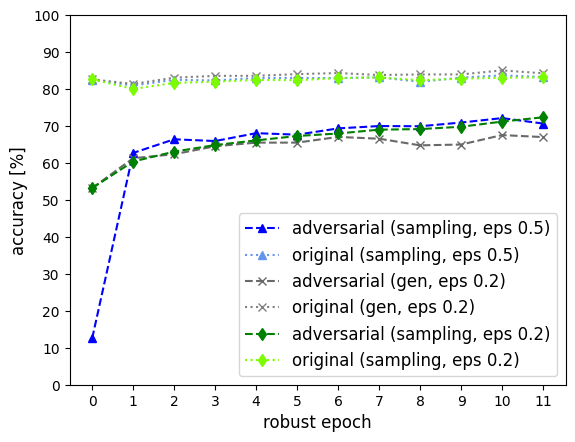

In [9]:
# plt.plot(x, rob_fash05_gen,  "s--", color="red", label="adversarial (generation)")
# plt.plot(x, test_fash05_gen, "s:", color="salmon", label="original (generation)")
plt.plot(x, rob_fash05,      "^--", color="blue", label="adversarial (sampling, eps 0.5)")
plt.plot(x, test_fash05,     "^:", color="cornflowerblue", label="original (sampling, eps 0.5)")

plt.plot(x, rob_fash02_gen,  "x--", color="dimgrey", label='adversarial (gen, eps 0.2)')
plt.plot(x, test_fash02_gen, "x:", color="gray", label="original (gen, eps 0.2)")
plt.plot(x, rob_fash02,     "d--", color="green", label="adversarial (sampling, eps 0.2)")
plt.plot(x, test_fash02,    "d:", color="lawngreen", label="original (sampling, eps 0.2)")

y = np.arange(0, 101, 10, dtype=int)


plt.xlabel("robust epoch", fontsize="large")
plt.ylabel("accuracy [%]", fontsize="large")
plt.legend(fontsize="large")
plt.yticks(y)
plt.xticks(x)
# plt.title("Fashion (eps 0.5)")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/appendix/robloop_fashion_02.pdf", bbox_inches="tight")

plt.show()

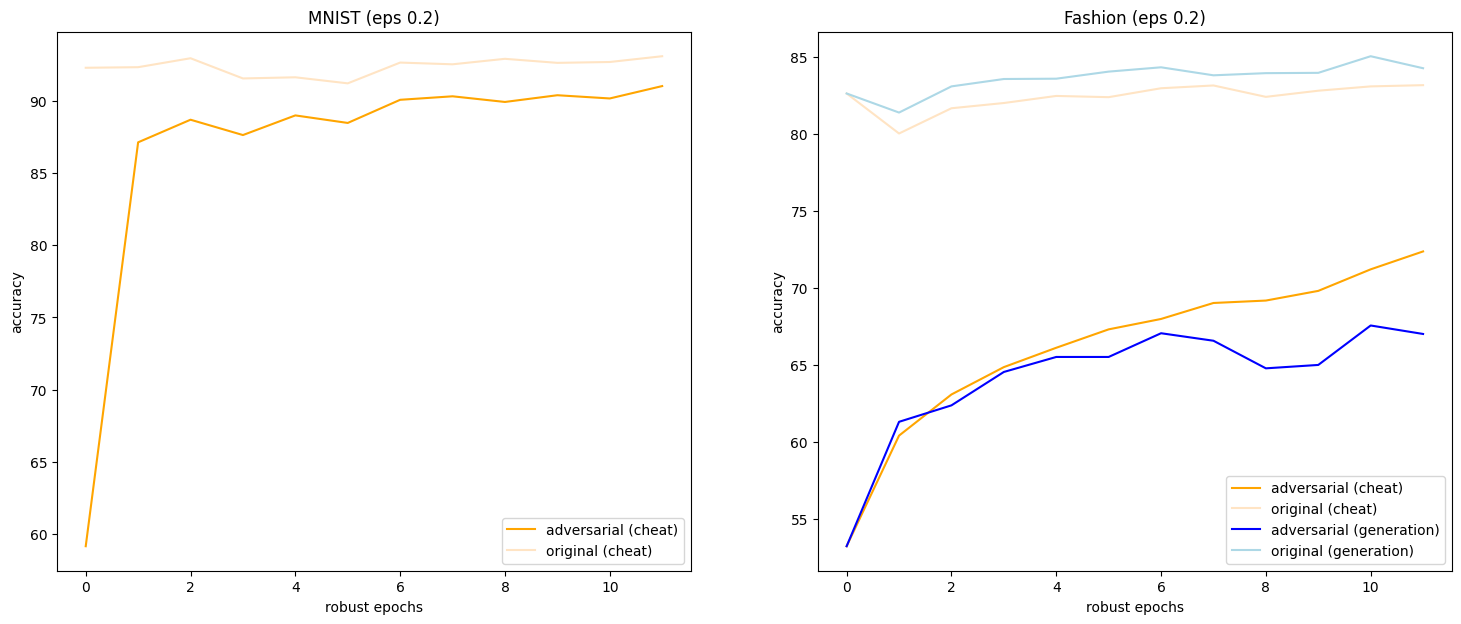

In [25]:

# comparison mnist - fashion with eps 0.2

plt.figure(figsize=(18, 7))

plt.subplot(121)
plt.plot(x, rob_mnist02,    "orange", label='adversarial (cheat)')
plt.plot(x, test_mnist02,   "bisque", label="original (cheat)")
plt.xlabel("robust epochs", fontsize="large")
plt.ylabel("accuracy", fontsize="large")
plt.legend()
plt.title("MNIST (eps 0.2)")

plt.subplot(122)
plt.plot(x, rob_fash02,     "orange", label="adversarial (cheat)")
plt.plot(x, test_fash02,    "bisque", label="original (cheat)")
plt.plot(x, rob_fash02_gen,  "blue", label='adversarial (generation)')
plt.plot(x, test_fash02_gen, "lightblue", label="original (generation)")
plt.xlabel("robust epochs", fontsize="large")
plt.ylabel("accuracy", fontsize="large")
plt.legend()
plt.title("Fashion (eps 0.2)")

plt.show()

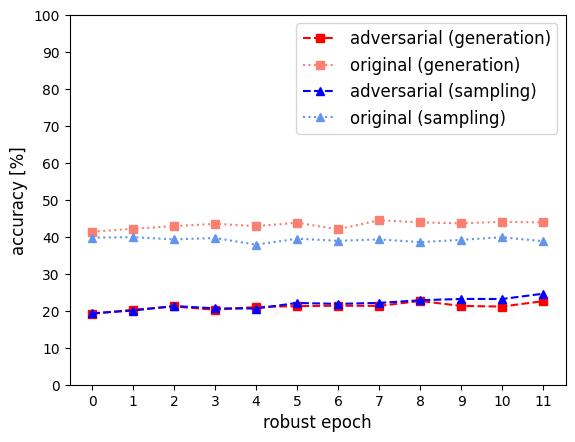

In [10]:
plt.plot(x, rob_cif01_gen,  "s--", color="red",   label="adversarial (generation)")
plt.plot(x, test_cif01_gen, "s:", color="salmon", label="original (generation)")
plt.plot(x, rob_cif01,      "^--", color="blue", label="adversarial (sampling)")
plt.plot(x, test_cif01,     "^:", color="cornflowerblue", label="original (sampling)")


plt.xticks(x)
plt.yticks(y)

plt.xlabel("robust epoch", fontsize="large")
plt.ylabel("accuracy [%]", fontsize="large")

plt.legend(fontsize="large")
# plt.title("CIFAR (eps 0.1)")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/comparison_cheat_gen_cifar.pdf", bbox_inches="tight")
plt.show()

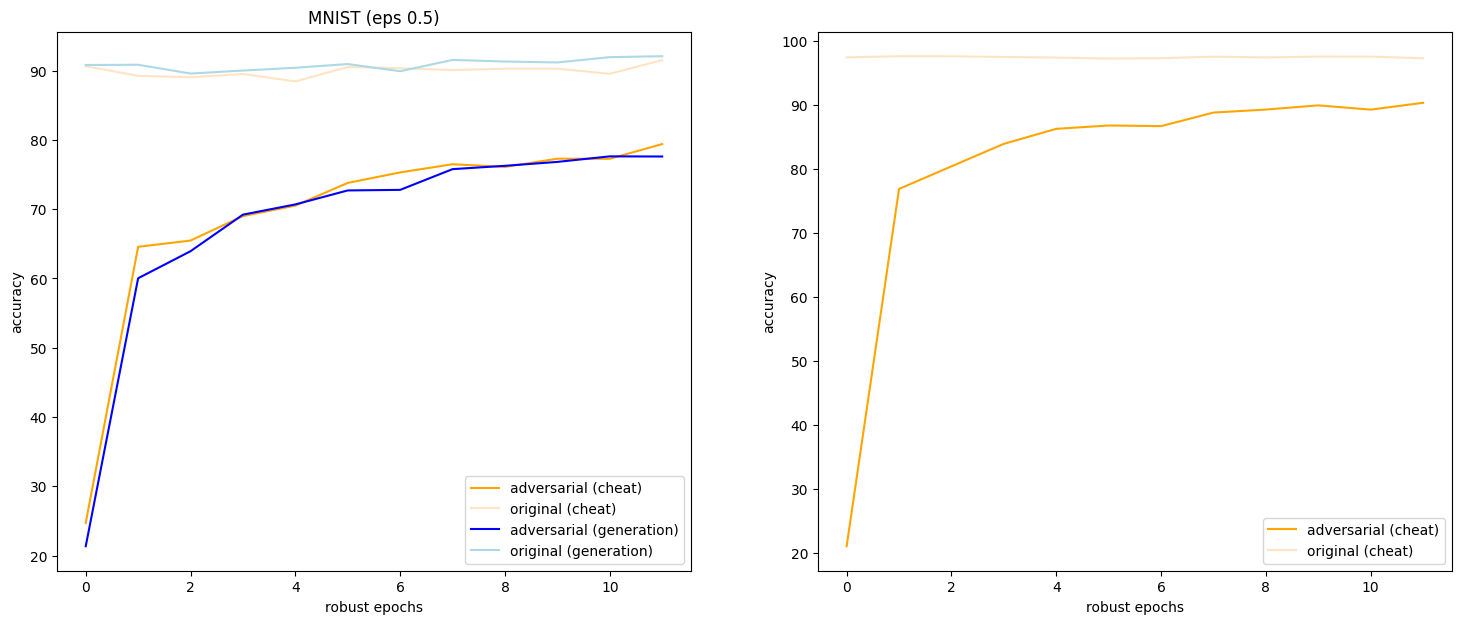

In [28]:

# comparison model 1 and model 4 on mnist with eps 0.5


plt.figure(figsize=(18, 7))

plt.subplot(121)
plt.plot(x, rob_mnist05[:n_robust_epoch],       "orange", label="adversarial (cheat)")
plt.plot(x, test_mnist05[:n_robust_epoch],      "bisque", label="original (cheat)")
plt.plot(x, rob_mnist05_gen[:n_robust_epoch],   "blue", label="adversarial (generation)")
plt.plot(x, test_mnist05_gen[:n_robust_epoch],  "lightblue", label="original (generation)")
plt.xlabel("robust epochs")
plt.ylabel("accuracy")
plt.legend()
plt.title("MNIST (eps 0.5)")


plt.subplot(122)
plt.plot(x, rob_mnist05_m4, "orange", label="adversarial (cheat)")
plt.plot(x, test_mnist05_m4, "bisque", label="original (cheat)")
plt.xlabel("robust epochs")
plt.ylabel("accuracy")
plt.legend()

plt.show()




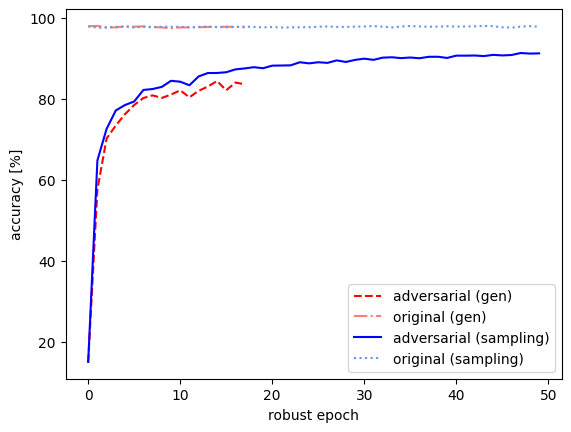

In [11]:


# full adversarial training

with open(f"{FILEPATH}/saved_graphs/32_robust_values_cheat_recreateTrue_mS5_epoch25_majority_mnistFULL.pickle", "rb") as file:
    rob_values = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/32_test_values_cheat_recreateTrue_mS5_epoch25_majority_mnistFULL.pickle", 'rb') as file:
    test_values = pickle.load(file)


tests = [97.96, 98.05, 97.71, 97.68, 97.9, 97.87, 97.93, 97.79, 97.67, 97.47, 97.68, 97.7, 97.71, 97.79, 97.81, 97.85, 97.83, 97.7]
robs = [14.98, 57.623, 70.225, 73.432, 76.23, 78.504, 80.225, 80.881, 80.246, 81.086, 82.131, 80.4, 81.998, 83.064, 84.416, 82.141, 84.057, 83.617]

l = len(tests)
assert l == len(robs)




x = np.arange(0, 50, dtype=int)

plt.plot(x[:l], robs, "--", color="red", label="adversarial (gen)")
plt.plot(x[:l], tests, "-.", color="salmon", label="original (gen)")

plt.plot(x, rob_values, "-", color="blue", label='adversarial (sampling)')
plt.plot(x, test_values, ":", color="cornflowerblue", label="original (sampling)")




# TODO plot generation data

plt.xlabel("robust epoch")
plt.ylabel("accuracy [%]")
plt.legend()

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/appendix/full_adv_train_mnist.pdf", bbox_inches="tight")


plt.show()






## Images : noise and % of modif

In [83]:
### comparison with noise images

train_set, _ = load_data("MNIST")

with open(f"{FILEPATH}/saved_generated_data/gendata_40000_eps0.5_noise.pickle", "rb") as file:
    noise_data = pickle.load(file)
with open(f"{FILEPATH}/saved_generated_data/gendata_40000_eps0.5_noiseHigh.pickle", "rb") as file:
    noise_data_high = pickle.load(file)

with open(f"{FILEPATH}/saved_generated_data/gendata_60000_eps0.5_mS1_mnist_fixed.pickle", 'rb') as file:
    mnist_05 = pickle.load(file)


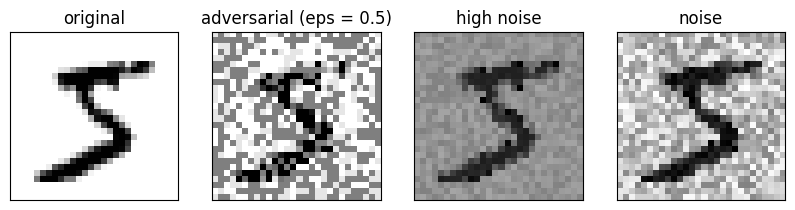

In [87]:
idx = 0

f = plt.figure(figsize=(10, 5))

f.add_subplot(1, 4, 1)
plt.imshow(train_set[idx][0].squeeze(), cmap="gray_r", vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.title("original")

f.add_subplot(1, 4, 2)
plt.imshow(mnist_05[idx][0].squeeze(), cmap="gray_r", vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.title("adversarial (eps = 0.5)")

f.add_subplot(1, 4, 3)
plt.imshow(noise_data_high[idx][0].squeeze(), cmap="gray_r", vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.title("high noise")

f.add_subplot(1, 4, 4)
plt.imshow(noise_data[idx][0].squeeze(), cmap="gray_r", vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.title("noise")

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/comparison_noise_adv.pdf", bbox_inches="tight")

plt.show()

In [2]:

def get_pourcent_modif_pixel(orig, adv):
    n = len(orig[0])
    count = 0
    for chan in range(len(orig)):
        for i in range(n):
            for j in range(n):
                if orig[chan, i, j] != adv[chan, i, j]:
                    count += 1
    return count / n**2


def get_stat_img_modif(dname, model_types, n=10, eps=0.5):
    train_set, test_set = load_data(dname)

    if dname == "CIFAR10":
        input_size = 32*32*3
        in_chan = 3
        mult = 8
    else:
        input_size = 28*28
        in_chan = 1
        mult = 7

    models = []
    for t in model_types:
        if t == 1:
            models.append(Model1(input_size, 10))
        elif t == 2:
            models.append(Model2(input_size, 10))
        elif t == 3:
            models.append(Model3(input_size, 10))
        else:
            models.append(Model4(in_chan, 10, mult))

    models_eval = []
    for model in models:
        train_dataloader = DataLoader(train_set, batch_size=64)
        test_dataloader = DataLoader(test_set, batch_size=64)
        train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False, verbose=False)
        models_eval.append(model.cvt_to_eval())
    
    modif = []
    args = get_args_jupyter(eps, models)
    for i in range(n):
        img, label = train_set[i]
        check_res, adv = search_adv_img_multiple_models(models_eval, img, label, get_classes(dname), args)
        if check_res == SolveResult.SAT:
            modif.append(get_pourcent_modif_pixel(img, adv))

    return np.mean(modif)





In [9]:
with open(f"{FILEPATH}/saved_generated_data/gendata_10000_eps0.1_mS1_mnist_fixed.pickle", "rb") as file:
    d01 = pickle.load(file)
    
with open(f"{FILEPATH}/saved_generated_data/saved_idxs_set_10000_0.1_mS1_mnist.pickle", "rb") as file:
    idx01 = pickle.load(file)
    
with open(f"{FILEPATH}/saved_generated_data/gendata_40000_eps0.2_mS1_mnist_fixed.pickle", "rb") as file:
    d02 = pickle.load(file)
    
with open(f"{FILEPATH}/saved_generated_data/saved_idxs_set_40000_0.2_mS1_mnist.pickle", "rb") as file:
    idx02 = pickle.load(file)
    
train_set, _ = load_data("MNIST")

In [11]:
modif = 0
for i in range(10):
    adv = d01[i][0]
    real = train_set[idx01[i]][0]
    modif += get_pourcent_modif_pixel(real, adv)

modif /= 10
print(f"with eps 0.1 : {modif}")


modif = 0
for i in range(10):
    adv = d02[i][0]
    real = train_set[idx02[i]][0]
    modif += get_pourcent_modif_pixel(real, adv)

modif /= 10
print(f"with eps 0.2 : {modif}")

with eps 0.1 : 0.6505102040816326
with eps 0.2 : 0.741454081632653


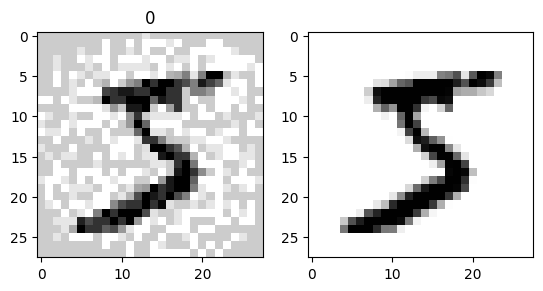

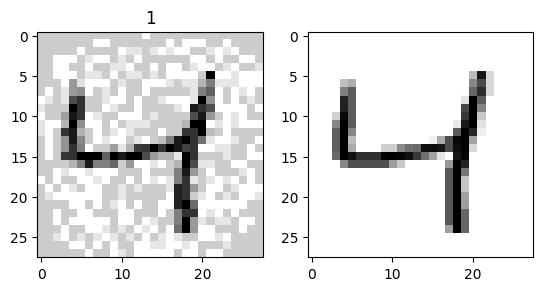

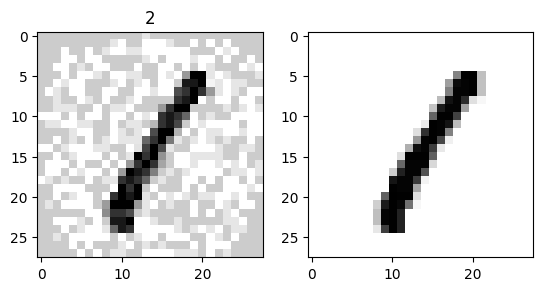

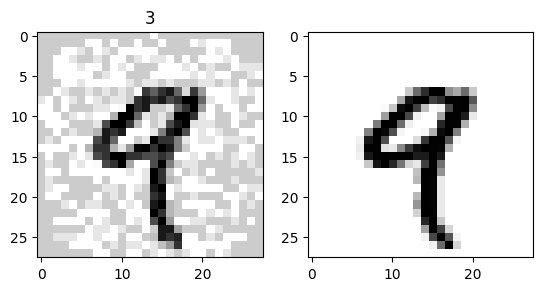

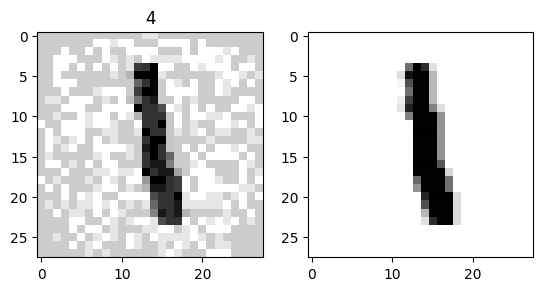

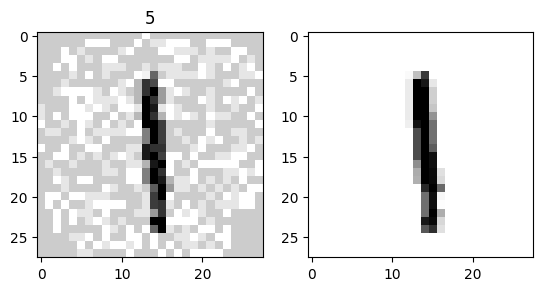

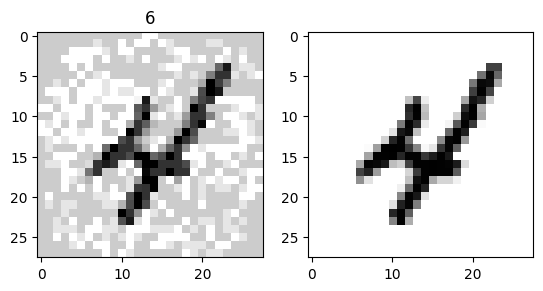

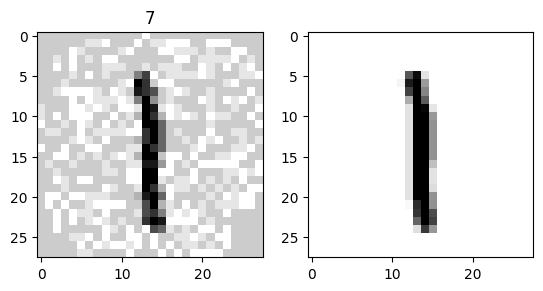

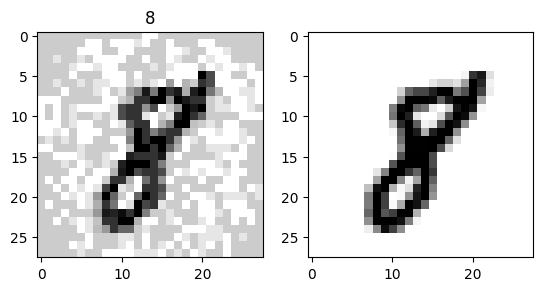

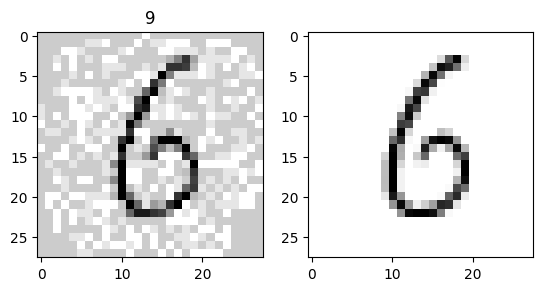

In [10]:

for i in range(10):
    plt.subplot(121)
    plt.imshow(d02[i][0].squeeze(), cmap="gray_r")
    plt.title(str(i))

    plt.subplot(122)
    plt.imshow(train_set[idx02[i]][0].squeeze(), cmap="gray_r")
    plt.show()

In [17]:
# stat mnist 0.5 - 1 model

for i in range(1, 5):
    score = get_stat_img_modif("MNIST", [i], n=10, eps=0.5)
    print(f"Model {i} : {score*100:.3f}%")


Model 1 : 76.339%
Model 2 : 78.571%
Model 3 : 78.151%
Model 4 : 78.622%


In [18]:
# stat mnist 0.2 - 1 model
for i in range(1, 5):
    score = get_stat_img_modif("MNIST", [i], n=10, eps=0.2)
    print(f"Model {i} : {score*100:.3f}%")

Model 1 : 79.401%
Model 2 : 78.546%
Model 3 : 78.380%
Model 4 : 78.406%


In [19]:
# stat fashion 0.5 - 1 model

for i in range(1, 5):
    score = get_stat_img_modif("Fashion", [i], n=10, eps=0.5)
    print(f"Model {i} : {score*100:.3f}%")

Model 1 : 85.842%
Model 2 : 86.416%
Model 3 : 86.416%
Model 4 : 86.416%


In [20]:
# stat fashion 0.2 - 1 model

for i in range(1, 5):
    score = get_stat_img_modif("Fashion", [i], n=10, eps=0.2)
    print(f"Model {i} : {score*100:.3f}%")

Model 1 : 85.034%
Model 2 : 84.413%
Model 3 : 84.043%
Model 4 : 86.148%


In [21]:
# stat cifar 0.1 - 1 model

for i in range(1, 5):
    score = get_stat_img_modif("CIFAR10", [i], n=10, eps=0.1)
    print(f"Model {i} : {score*100:.3f}%")

# to be divided by 3

Model 1 : 297.179%
Model 2 : 297.041%
Model 3 : 296.853%
Model 4 : 296.777%


## images with evolution of eps

In [ ]:

train_set, test_set = load_data("MNIST")
train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)

model = Model1(28*28, 10)
model = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False, verbose=False)



In [61]:
eps_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
advs = []

model = model.cvt_to_eval()

for eps in eps_range:
    args = get_args_jupyter(eps, model)
    img, label = train_set[0]
    check_result, adv_img = search_adv_image(model, img, label, get_classes("MNIST"), args)

    if check_result == SolveResult.SAT:
        advs.append(adv_img)

running build_ext
skipping '/home/ben/.pyxbld/temp.linux-x86_64-3.10/pyrex/eevbnn/_minisatcs.cpp' Cython extension (up-to-date)
skipping 'eevbnn._minisatcs' extension (up-to-date)


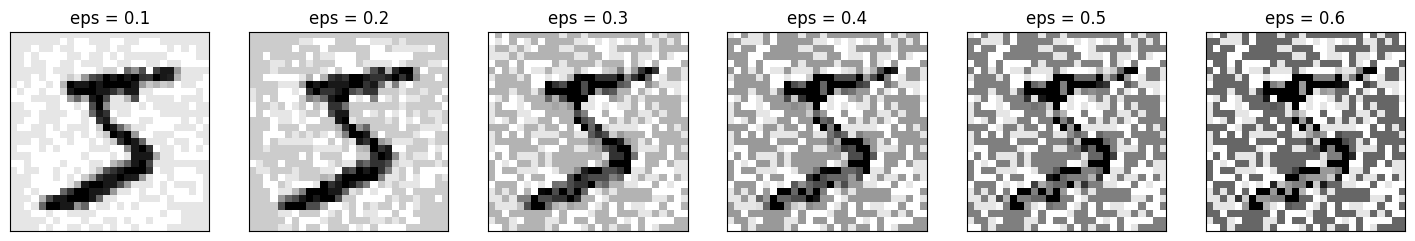

In [63]:

f = plt.figure(figsize=(18, 5))

for i, adv in enumerate(advs):
    f.add_subplot(1, 6, i+1)
    plt.imshow(adv.squeeze(), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"eps = {eps_range[i]}")

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/eps_evolution_mnist.pdf", bbox_inches="tight")

plt.show()

In [64]:
train_set, test_set = load_data("Fashion")
train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)

model = Model1(28*28, 10)
model = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False, verbose=False)

In [65]:
eps_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
advs = []

model = model.cvt_to_eval()

for eps in eps_range:
    args = get_args_jupyter(eps, model)
    img, label = train_set[0]
    check_result, adv_img = search_adv_image(model, img, label, get_classes("Fashion"), args)

    if check_result == SolveResult.SAT:
        advs.append(adv_img)

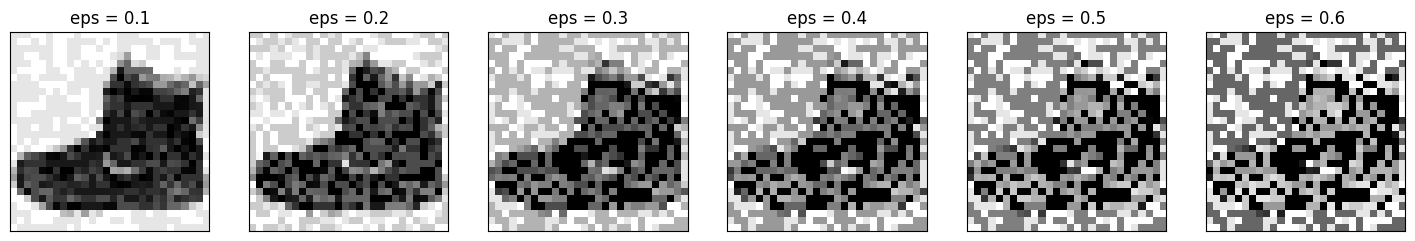

In [66]:

f = plt.figure(figsize=(18, 5))

for i, adv in enumerate(advs):
    f.add_subplot(1, 6, i+1)
    plt.imshow(adv.squeeze(), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"eps = {eps_range[i]}")

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/eps_evolution_fashion.pdf", bbox_inches="tight")

plt.show()

In [67]:
train_set, test_set = load_data("CIFAR10")
train_dataloader = DataLoader(train_set, batch_size=64)
test_dataloader = DataLoader(test_set, batch_size=64)

model = Model1(32*32*3, 10)
model = train_test_model(model, train_dataloader, test_dataloader, epochs=5, save=False, verbose=False)

In [80]:
# eps_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
eps_range = [0.05, 0.08, 0.1, 0.15, 0.2, 0.3]
advs = []

# model = model.cvt_to_eval()

for eps in eps_range:
    args = get_args_jupyter(eps, model)
    img, label = train_set[1]
    check_result, adv_img = search_adv_image(model, img, label, get_classes("CIFAR10"), args)

    if check_result == SolveResult.SAT:
        advs.append(adv_img)

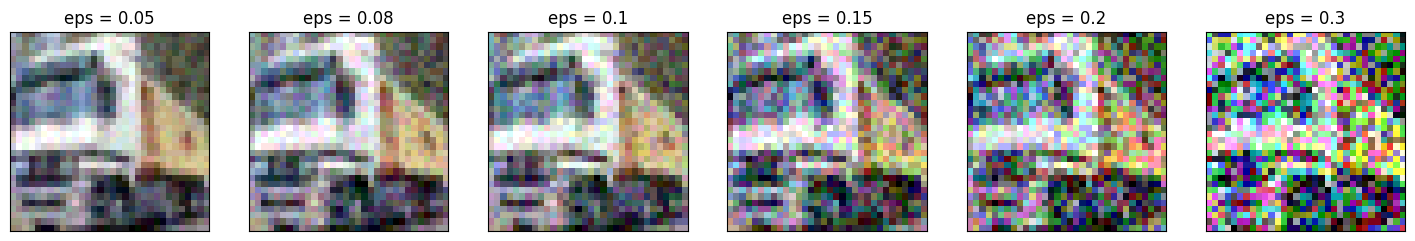

In [81]:

f = plt.figure(figsize=(18, 5))

for i, adv in enumerate(advs):
    f.add_subplot(1, 6, i+1)
    plt.imshow(np.transpose(adv, (1, 2, 0)), interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"eps = {eps_range[i]}")

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/eps_evolution_cifar.pdf", bbox_inches="tight")

plt.show()

## Graph epsilon evolution

In [8]:
def plot_eps_graph(values, labels, fname, x=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], title="", shapes=[]):
    for i, val in enumerate(values):
        plt.plot(x, val, shapes[i], label=labels[i])
    plt.xlabel("epsilon", fontsize="x-large")
    plt.xticks(x)
    y = np.arange(0, 1.1, 0.2)
    plt.yticks(y)
    plt.ylabel("proportion of SAT cases", fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.title(title)
    plt.savefig(f"{FILEPATH}/saved_eps_graphs/{fname}.pdf", bbox_inches="tight")
    plt.show()
    

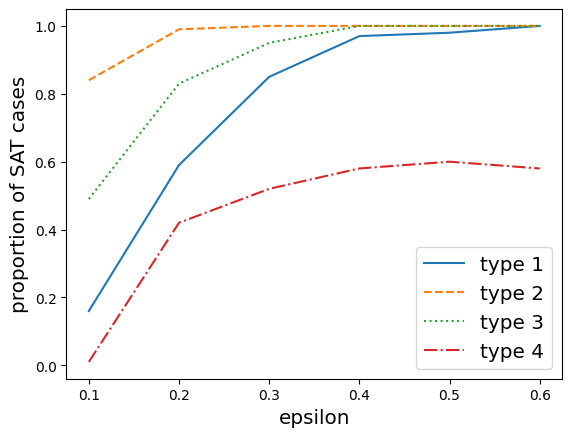

In [13]:

values = []
labels = []

for i in range(1, 5):
    with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_MNIST_m{i}_notrain.pickle", "rb") as file:
        values.append(pickle.load(file))
        labels.append(f"type {i}")

shapes = ["-", "--", ":", "-."]

plot_eps_graph(values, labels, "eps_graph_MNIST_notrain", shapes=shapes)

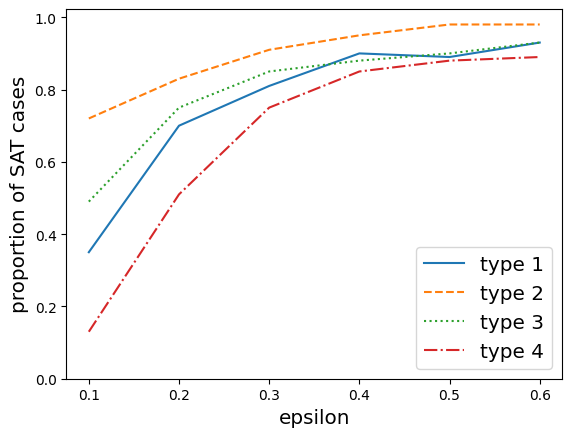

In [14]:
values = []
labels = []

for i in range(1, 5):
    with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_Fashion_m{i}_notrain.pickle", "rb") as file:
        values.append(pickle.load(file))
        labels.append(f"type {i}")
        
shapes = ["-", "--", ":", "-."]
        
plot_eps_graph(values, labels, "eps_graph_FASHION_notrain", shapes=shapes)

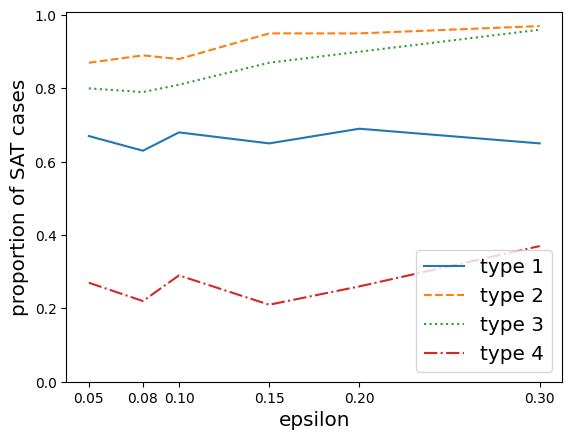

In [15]:
values = []
labels = []

for i in range(1, 5):
    with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_CIFAR10_m{i}_notrain.pickle", "rb") as file:
        values.append(pickle.load(file))
        labels.append(f"type {i}")
    
shapes = ["-", "--", ":", "-."]   
plot_eps_graph(values, labels, "eps_graph_CIFAR_notrain", x=[0.05, 0.08, 0.1, 0.15, 0.2, 0.3], shapes=shapes)

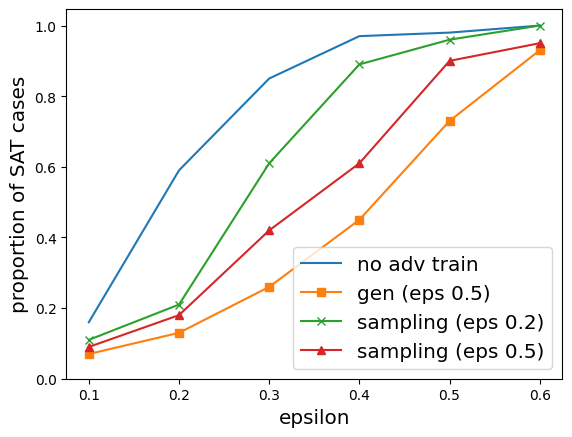

In [9]:
values = []
labels = []
shapes = []

with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_MNIST_m1_notrain.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("no adv train")
    shapes.append("-")

with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_MNIST_m1_gen05.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("gen (eps 0.5)")
    shapes.append("s-")
    
with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_MNIST_m1_cheat02.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("sampling (eps 0.2)")
    shapes.append("x-")

with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_MNIST_m1_cheat05.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("sampling (eps 0.5)")
    shapes.append("^-")
        
plot_eps_graph(values, labels, "eps_graph_MNIST_m1_comparison", shapes=shapes)

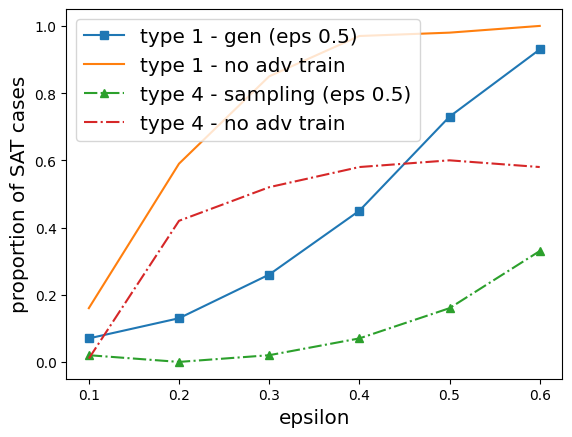

In [12]:
values = []
labels = []
shapes = []

with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_MNIST_m1_gen05.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("type 1 - gen (eps 0.5)")
    shapes.append("s-")

with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_MNIST_m1_notrain.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("type 1 - no adv train")
    shapes.append("-")

with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_MNIST_m4_cheat05.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("type 4 - sampling (eps 0.5)")
    shapes.append("^-.")

with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_MNIST_m4_notrain.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("type 4 - no adv train")
    shapes.append("-.")


plot_eps_graph(values, labels, "eps_graph_MNIST_t14_comparison", shapes=shapes)


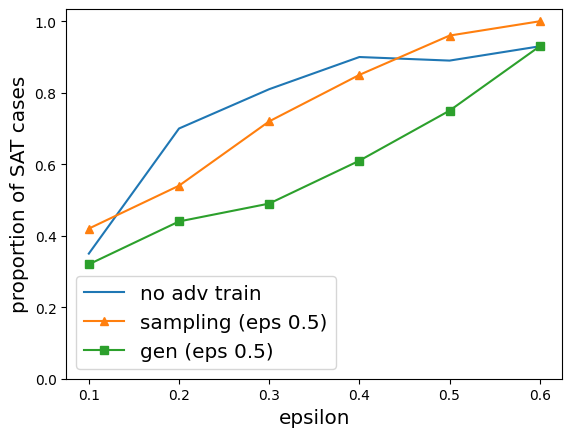

In [10]:
values = []
labels = []
shapes = []

with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_Fashion_m1_notrain.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("no adv train")
    shapes.append("-")
    
with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_FASHION_m1_cheat05.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("sampling (eps 0.5)")
    shapes.append("^-")
    
with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_FASHION_m1_gen05.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("gen (eps 0.5)")
    shapes.append("s-")
    
plot_eps_graph(values, labels, "eps_graph_FASHION_m1_comparison", shapes=shapes)

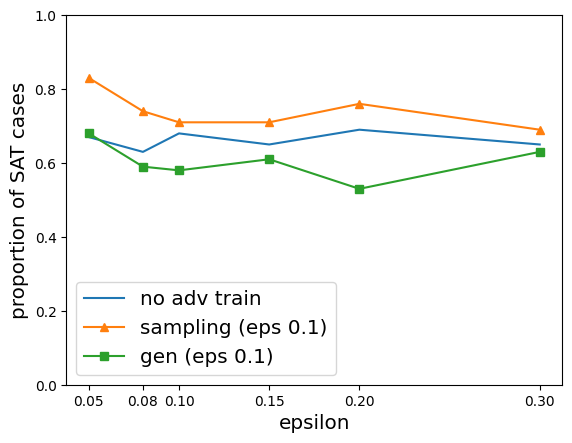

In [11]:
values = []
labels = []
shapes = []

with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_CIFAR10_m1_notrain.pickle", 'rb') as file:
    values.append(pickle.load(file))
    labels.append("no adv train")
    shapes.append("-")

with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_CIFAR_m1_cheat01.pickle", 'rb') as file:
    values.append(pickle.load(file))
    labels.append("sampling (eps 0.1)")
    shapes.append("^-")
    
with open(f"{FILEPATH}/saved_eps_graphs/sat_cases_CIFAR_m1_gen01.pickle", "rb") as file:
    values.append(pickle.load(file))
    labels.append("gen (eps 0.1)")    
    shapes.append("s-")


plot_eps_graph(values, labels, "eps_graph_CIFAR_m1_comparison.pdf", x=[0.05, 0.08, 0.1, 0.15, 0.2, 0.3], shapes=shapes)


## robust metric measures

tests 36 - 37 - 38 - 39 - 40 - 41

#### mnist 05

In [13]:

with open(f"{FILEPATH}/saved_graphs/36_abs_robust_gen_mnist05.pickle", "rb") as file:
    abs_robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/36_abs_test_gen_mnist05.pickle", "rb") as file:
    abs_test_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/36_inv_robust_gen_mnist05.pickle", "rb") as file:
    inv_robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/36_inv_test_gen_mnist05.pickle", "rb") as file:
    inv_test_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/36_ratio_robust_gen_mnist05.pickle", "rb") as file:
    ratio_robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/36_ratio_test_gen_mnist05.pickle", "rb") as file:
    ratio_test_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/36_robust_values_gen_mnist05.pickle", "rb") as file:
    robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/36_test_values_gen_mnist05.pickle", "rb") as file:
    test_gen = pickle.load(file)
    
with open(f"{FILEPATH}/saved_graphs/37_abs_robust_cheat_mnist05.pickle", "rb") as file:
    abs_robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/37_abs_test_cheat_mnist05.pickle", "rb") as file:
    abs_test_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/37_inv_robust_cheat_mnist05.pickle", "rb") as file:
    inv_robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/37_inv_test_cheat_mnist05.pickle", "rb") as file:
    inv_test_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/37_ratio_robust_cheat_mnist05.pickle", "rb") as file:
    ratio_robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/37_ratio_test_cheat_mnist05.pickle", "rb") as file:
    ratio_test_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/37_robust_values_cheat_mnist05.pickle", "rb") as file:
    robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/37_test_values_cheat_mnist05.pickle", "rb") as file:
    test_cheat = pickle.load(file)


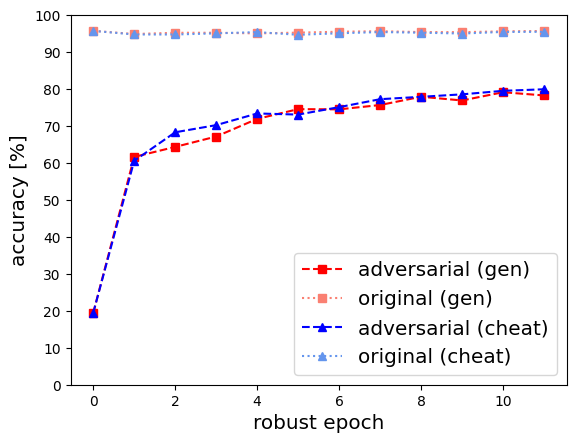

In [15]:
x = np.arange(0, 12, dtype=int)
y = np.arange(0, 101, 10, dtype=int)

plt.plot(x, robust_gen,     "s--", color="red",     label="adversarial (gen)")
plt.plot(x, test_gen,       "s:", color="salmon",     label="original (gen)")
plt.plot(x, robust_cheat,   "^--", color="blue",     label="adversarial (sampling)")
plt.plot(x, test_cheat,     "^:", color="cornflowerblue",     label="original (sampling)")

plt.yticks(y)

plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("accuracy [%]", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/mnist05_adv_acc.pdf", bbox_inches="tight")
plt.show()


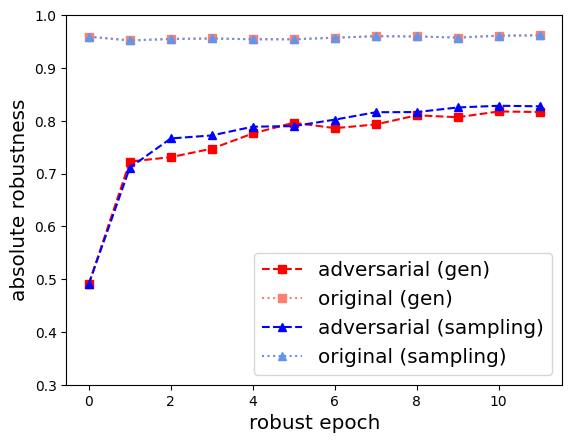

In [14]:
x = np.arange(0, 12, dtype=int)
y = np.arange(0.3, 1.1, 0.1)
plt.plot(x, abs_robust_gen,     "s--", color="red",             label="adversarial (gen)")
plt.plot(x, abs_test_gen,       "s:", color="salmon",   label="original (gen)")
plt.plot(x, abs_robust_cheat,   "^--", color="blue",              label="adversarial (sampling)")
plt.plot(x, abs_test_gen,       "^:", color="cornflowerblue",           label="original (sampling)")
plt.yticks(y)
plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("absolute robustness", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/mnist05_abs_rob.pdf", bbox_inches="tight")
plt.show()


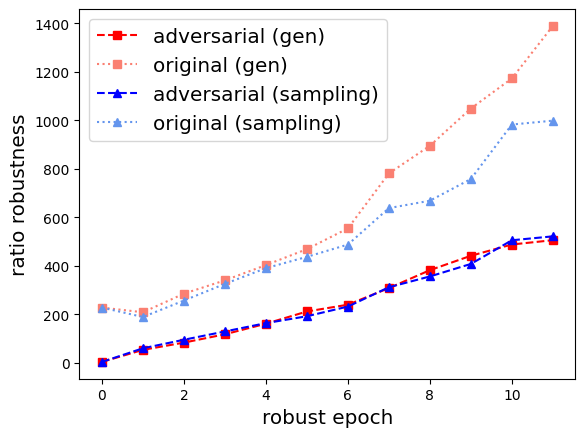

In [15]:
x = np.arange(0, 12, dtype=int)

plt.plot(x, ratio_robust_gen,       "s--", color="red",             label="adversarial (gen)")
plt.plot(x, ratio_test_gen,         "s:", color="salmon",   label="original (gen)")
plt.plot(x, ratio_robust_cheat,     "^--", color="blue",              label="adversarial (sampling)")
plt.plot(x, ratio_test_cheat,       "^:", color="cornflowerblue",           label="original (sampling)")

plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("ratio robustness", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/mnist05_ratio.pdf", bbox_inches="tight")
plt.show()

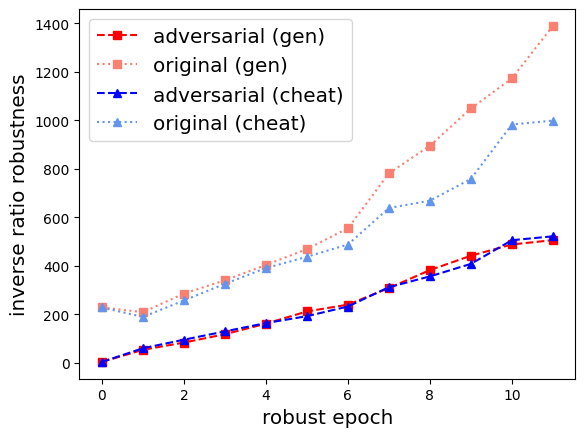

In [18]:
x = np.arange(0, 12, dtype=int)

plt.plot(x, inv_robust_gen,     "s--", color="red",             label="adversarial (gen)")
plt.plot(x, inv_test_gen,       "s:", color="salmon",   label="original (gen)")
plt.plot(x, inv_robust_cheat,   "^--", color="blue",              label="adversarial (sampling)")
plt.plot(x, inv_test_cheat,     "^:", color="cornflowerblue",           label="original (sampling)")

plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("inverse ratio robustness", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/mnist05_inv_ratio.pdf", bbox_inches="tight")
plt.show()

#### fashion 05

In [16]:
with open(f"{FILEPATH}/saved_graphs/39_abs_robust_gen_fashion05.pickle", "rb") as file:
    abs_robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/39_abs_test_gen_fashion05.pickle", "rb") as file:
    abs_test_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/39_inv_robust_gen_fashion05.pickle", "rb") as file:
    inv_robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/39_inv_test_gen_fashion05.pickle", "rb") as file:
    inv_test_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/39_ratio_robust_gen_fashion05.pickle", "rb") as file:
    ratio_robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/39_ratio_test_gen_fashion05.pickle", "rb") as file:
    ratio_test_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/39_robust_values_gen_fashion05.pickle", "rb") as file:
    robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/39_test_values_gen_fashion05.pickle", "rb") as file:
    test_gen = pickle.load(file)
    
with open(f"{FILEPATH}/saved_graphs/38_abs_robust_cheat_fashion05.pickle", "rb") as file:
    abs_robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/38_abs_test_cheat_fashion05.pickle", "rb") as file:
    abs_test_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/38_inv_robust_cheat_fashion05.pickle", "rb") as file:
    inv_robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/38_inv_test_cheat_fashion05.pickle", "rb") as file:
    inv_test_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/38_ratio_robust_cheat_fashion05.pickle", "rb") as file:
    ratio_robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/38_ratio_test_cheat_fashion05.pickle", "rb") as file:
    ratio_test_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/38_robust_values_cheat_fashion05.pickle", "rb") as file:
    robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/38_test_values_cheat_fashion05.pickle", "rb") as file:
    test_cheat = pickle.load(file)

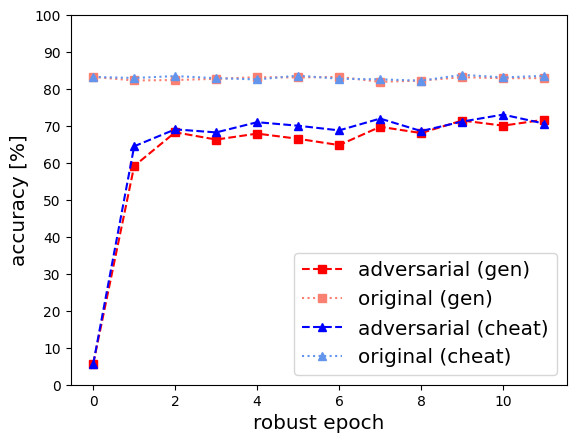

In [20]:
x = np.arange(0, 12, dtype=int)
y = np.arange(0, 101, 10, dtype=int)


plt.plot(x, robust_gen,     "s--", color="red",     label="adversarial (gen)")
plt.plot(x, test_gen,       "s:", color="salmon",     label="original (gen)")
plt.plot(x, robust_cheat,   "^--", color="blue",     label="adversarial (cheat)")
plt.plot(x, test_cheat,     "^:", color="cornflowerblue",     label="original (cheat)")
plt.yticks(y)
plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("accuracy [%]", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/fashion05_adv_acc.pdf", bbox_inches="tight")
plt.show()

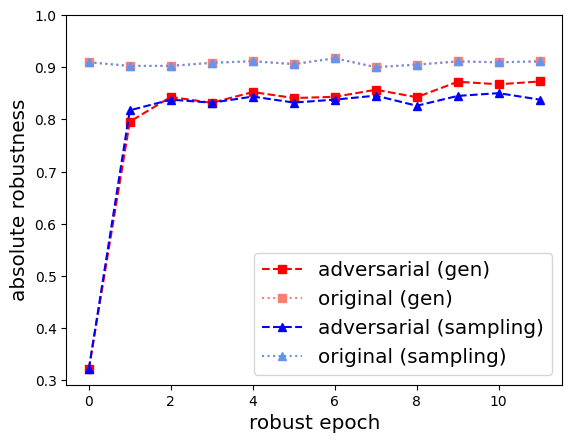

In [17]:
x = np.arange(0, 12, dtype=int)
y = np.arange(0.3, 1.1, 0.1)
plt.plot(x, abs_robust_gen,     "s--", color="red",             label="adversarial (gen)")
plt.plot(x, abs_test_gen,       "s:", color="salmon",   label="original (gen)")
plt.plot(x, abs_robust_cheat,   "^--", color="blue",              label="adversarial (sampling)")
plt.plot(x, abs_test_gen,       "^:", color="cornflowerblue",           label="original (sampling)")
plt.yticks(y)
plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("absolute robustness", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/fashion05_abs_rob.pdf", bbox_inches="tight")
plt.show()


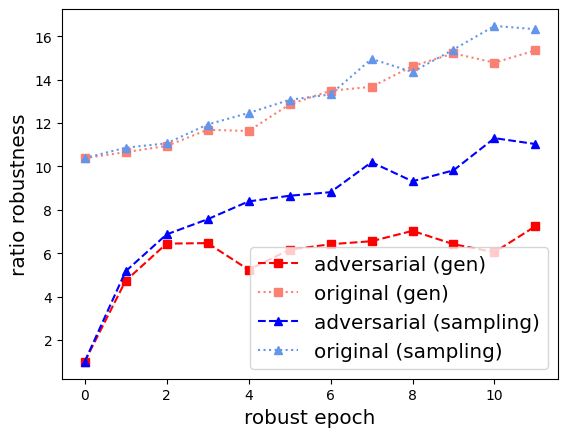

In [18]:
x = np.arange(0, 12, dtype=int)

plt.plot(x, ratio_robust_gen,       "s--", color="red",             label="adversarial (gen)")
plt.plot(x, ratio_test_gen,         "s:", color="salmon",   label="original (gen)")
plt.plot(x, ratio_robust_cheat,     "^--", color="blue",              label="adversarial (sampling)")
plt.plot(x, ratio_test_cheat,       "^:", color="cornflowerblue",           label="original (sampling)")

plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("ratio robustness", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/fashion05_ratio.pdf", bbox_inches="tight")
plt.show()

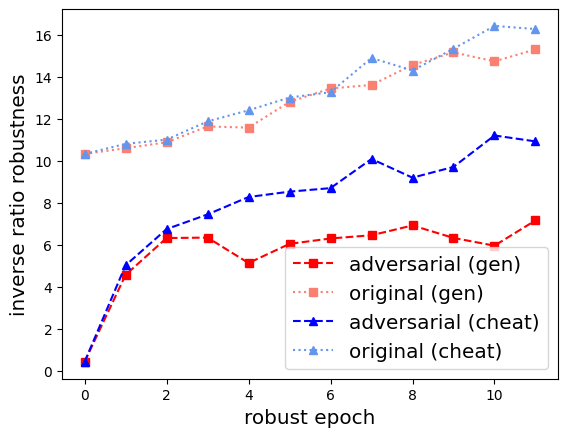

In [23]:
x = np.arange(0, 12, dtype=int)

plt.plot(x, inv_robust_gen,     "s--", color="red",             label="adversarial (gen)")
plt.plot(x, inv_test_gen,       "s:", color="salmon",   label="original (gen)")
plt.plot(x, inv_robust_cheat,   "^--", color="blue",              label="adversarial (cheat)")
plt.plot(x, inv_test_cheat,     "^:", color="cornflowerblue",           label="original (cheat)")

plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("inverse ratio robustness", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/fashion05_inv_ratio.pdf", bbox_inches="tight")
plt.show()

#### cifar 01

In [19]:
with open(f"{FILEPATH}/saved_graphs/41_abs_robust_gen_cifar01.pickle", "rb") as file:
    abs_robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/41_abs_test_gen_cifar01.pickle", "rb") as file:
    abs_test_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/41_inv_robust_gen_cifar01.pickle", "rb") as file:
    inv_robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/41_inv_test_gen_cifar01.pickle", "rb") as file:
    inv_test_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/41_ratio_robust_gen_cifar01.pickle", "rb") as file:
    ratio_robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/41_ratio_test_gen_cifar01.pickle", "rb") as file:
    ratio_test_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/41_robust_values_gen_cifar01.pickle", "rb") as file:
    robust_gen = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/41_test_values_gen_cifar01.pickle", "rb") as file:
    test_gen = pickle.load(file)
    
with open(f"{FILEPATH}/saved_graphs/40_abs_robust_cheat_cifar01.pickle", "rb") as file:
    abs_robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/40_abs_test_cheat_cifar01.pickle", "rb") as file:
    abs_test_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/40_inv_robust_cheat_cifar01.pickle", "rb") as file:
    inv_robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/40_inv_test_cheat_cifar01.pickle", "rb") as file:
    inv_test_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/40_ratio_robust_cheat_cifar01.pickle", "rb") as file:
    ratio_robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/40_ratio_test_cheat_cifar01.pickle", "rb") as file:
    ratio_test_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/40_robust_values_cheat_cifar01.pickle", "rb") as file:
    robust_cheat = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/40_test_values_cheat_cifar01.pickle", "rb") as file:
    test_cheat = pickle.load(file)

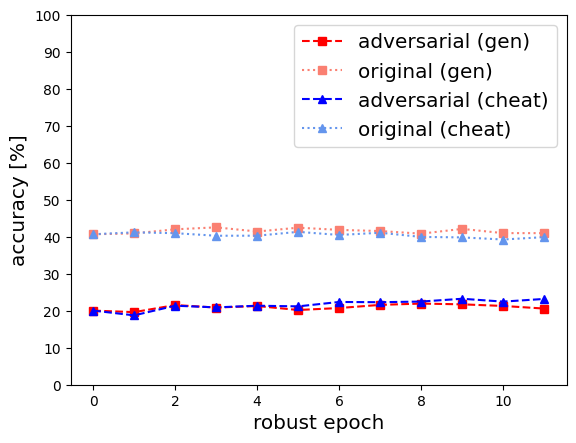

In [25]:
x = np.arange(0, 12, dtype=int)
y = np.arange(0, 101, 10, dtype=int)
plt.plot(x, robust_gen,     "s--", color="red",     label="adversarial (gen)")
plt.plot(x, test_gen,       "s:", color="salmon",     label="original (gen)")
plt.plot(x, robust_cheat,   "^--", color="blue",     label="adversarial (cheat)")
plt.plot(x, test_cheat,     "^:", color="cornflowerblue",     label="original (cheat)")
plt.yticks(y)
plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("accuracy [%]", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/cifar01_adv_acc.pdf", bbox_inches="tight")
plt.show()

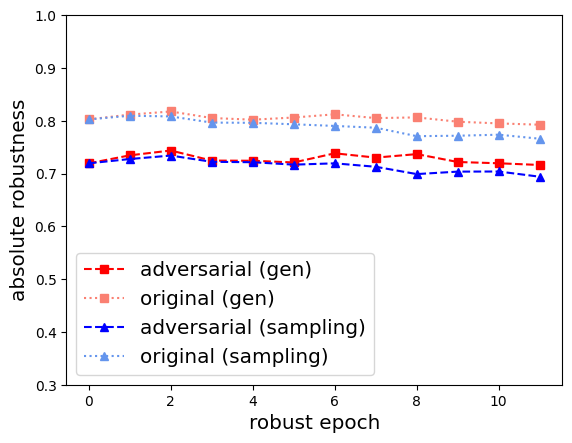

In [20]:
x = np.arange(0, 12, dtype=int)
y = np.arange(0.3, 1.1, 0.1)
plt.plot(x, abs_robust_gen,     "s--", color="red",             label="adversarial (gen)")
plt.plot(x, abs_test_gen,       "s:", color="salmon",   label="original (gen)")
plt.plot(x, abs_robust_cheat,   "^--", color="blue",              label="adversarial (sampling)")
plt.plot(x, abs_test_cheat,     "^:", color="cornflowerblue",           label="original (sampling)")
plt.yticks(y)
plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("absolute robustness", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/cifar01_abs_rob.pdf", bbox_inches="tight")
plt.show()

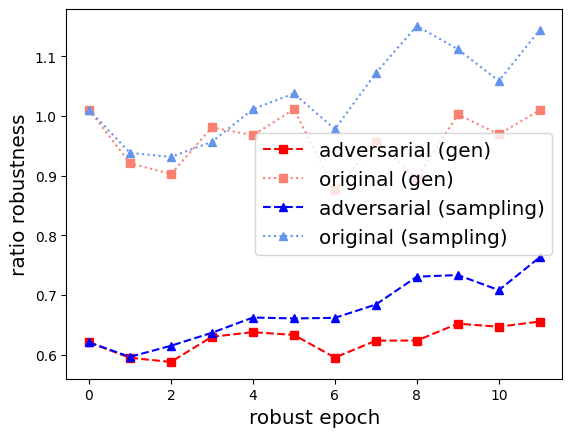

In [21]:
x = np.arange(0, 12, dtype=int)

plt.plot(x, ratio_robust_gen,       "s--", color="red",             label="adversarial (gen)")
plt.plot(x, ratio_test_gen,         "s:", color="salmon",   label="original (gen)")
plt.plot(x, ratio_robust_cheat,     "^--", color="blue",              label="adversarial (sampling)")
plt.plot(x, ratio_test_cheat,       "^:", color="cornflowerblue",           label="original (sampling)")

plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("ratio robustness", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/cifar01_ratio.pdf", bbox_inches="tight")
plt.show()

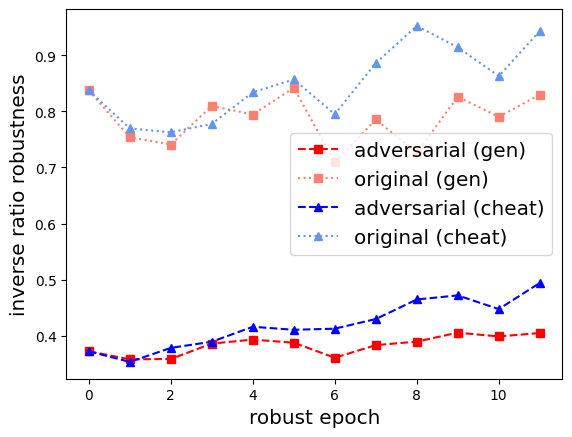

In [28]:
x = np.arange(0, 12, dtype=int)

plt.plot(x, inv_robust_gen,     "s--", color="red",             label="adversarial (gen)")
plt.plot(x, inv_test_gen,       "s:", color="salmon",   label="original (gen)")
plt.plot(x, inv_robust_cheat,   "^--", color="blue",              label="adversarial (cheat)")
plt.plot(x, inv_test_cheat,     "^:", color="cornflowerblue",           label="original (cheat)")

plt.xlabel("robust epoch", fontsize="x-large")
plt.ylabel("inverse ratio robustness", fontsize="x-large")
plt.legend(fontsize="x-large")
plt.savefig(f"{FILEPATH}/saved_imgs_thesis/robust_metrics/cifar01_inv_ratio.pdf", bbox_inches="tight")
plt.show()

## Comparison adv vs noise 

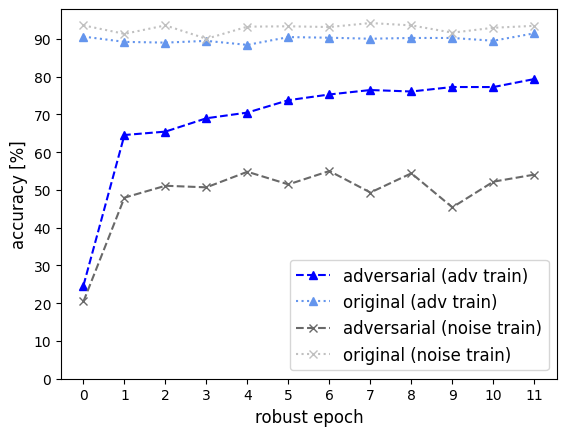

In [44]:
# plot acc on adv with adv train vs noise 

with open(f"{FILEPATH}/saved_graphs/42_2_test_values_cheat_recreateTrue_mS5_epoch25_majority_advtrain_noisetest.pickle", "rb") as file:
    test_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/42_2_robust_values_cheat_recreateTrue_mS5_epoch25_majority_advtrain_noisetest.pickle", "rb") as file:
    rob_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/23_robust_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    rob_adv = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/23_test_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    test_adv = pickle.load(file)

x = np.arange(0, 12, dtype=int)
y = np.arange(0, 100, 10, dtype=int)    
    
plt.plot(x, rob_adv[:12], "^--", color="blue", label="adversarial (adv train)")  
plt.plot(x, test_adv[:12], "^:", color="cornflowerblue", label="original (adv train)")
plt.plot(x, rob_noise[:12], "x--", color="dimgray", label="adversarial (noise train)")
plt.plot(x, np.array(test_noise), "x:", color="silver", label="original (noise train)")

plt.xlabel("robust epoch", fontsize="large")
plt.ylabel("accuracy [%]", fontsize="large")

plt.xticks(x)
plt.yticks(y)
plt.legend(fontsize="large")

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/comparison_adv_noise_onadv_v2.pdf", bbox_inches="tight")

plt.show()    



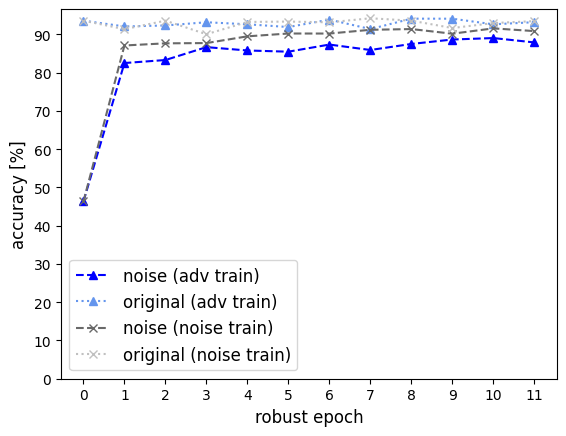

In [45]:
# test on noise

with open(f"{FILEPATH}/saved_graphs/43_2_test_values_cheat_recreateTrue_mS5_epoch25_majority_advtrain_noisetest.pickle", "rb") as file:
    test_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/43_2_robust_values_cheat_recreateTrue_mS5_epoch25_majority_advtrain_noisetest.pickle", "rb") as file:
    rob_noise = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/44_2_robust_values_cheat_recreateTrue_mS5_epoch25_majority_advtrain_noisetest.pickle", "rb") as file:
    rob_adv = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/44_2_test_values_cheat_recreateTrue_mS5_epoch25_majority_advtrain_noisetest.pickle", "rb") as file:
    test_adv = pickle.load(file)
    

x = np.arange(0, 12, dtype=int)
y = np.arange(0, 100, 10, dtype=int)    
    
plt.plot(x, rob_adv, "^--", color="blue", label="noise (adv train)")  
plt.plot(x, test_adv, "^:", color="cornflowerblue", label="original (adv train)")
plt.plot(x, rob_noise, "x--", color="dimgray", label="noise (noise train)")
plt.plot(x, test_noise, "x:", color="silver", label="original (noise train)")
    
plt.xlabel("robust epoch", fontsize="large")
plt.ylabel("accuracy [%]", fontsize="large")

plt.xticks(x)
plt.yticks(y)
plt.legend(fontsize="large")

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/comparison_adv_noise_onnoise_v2.pdf", bbox_inches="tight")

plt.show()    

## comparison with classical NN

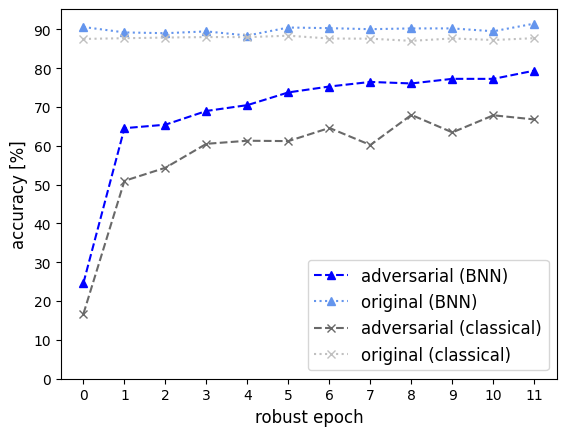

In [47]:
with open(f"{FILEPATH}/saved_graphs/23_robust_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    rob_bnn = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/23_test_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    test_bnn = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/47_2_test_values_standardModel_maj.pickle", "rb") as file:
    rob_nn = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/47_2_robust_values_standardModel_maj.pickle", "rb") as file:
    test_nn = pickle.load(file)
## NB : mistake when saving file, rob <-> test
    
    
x = np.arange(0, 12, dtype=int)
y = np.arange(0, 100, 10, dtype=int)    
    
plt.plot(x, rob_bnn[:12], "^--", color="blue", label="adversarial (BNN)")  
plt.plot(x, test_bnn[:12], "^:", color="cornflowerblue", label="original (BNN)")

plt.plot(x, rob_nn, "x--", color="dimgray", label="adversarial (classical)")
plt.plot(x, test_nn, "x:", color="silver", label="original (classical)")

plt.xlabel("robust epoch", fontsize="large")
plt.ylabel("accuracy [%]", fontsize="large")    
plt.xticks(x)
plt.yticks(y)
plt.legend(fontsize="large")


plt.savefig(f"{FILEPATH}/saved_imgs_thesis/comparison_bnn_classical.pdf", bbox_inches="tight")

plt.show()   
    
    

## graphes annexes

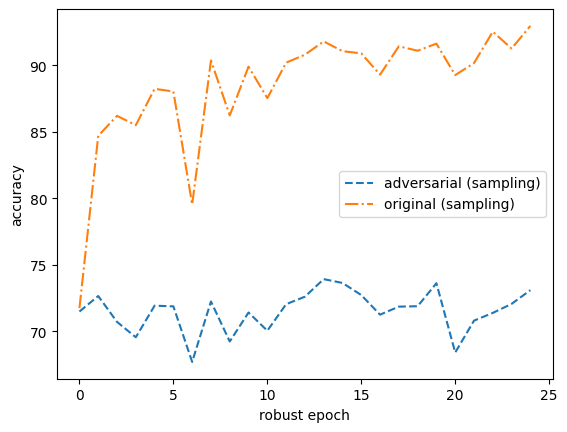

In [3]:

with open(f"{FILEPATH}/saved_graphs/17_robust_values_cheat_recreateTrue_mS5_epoch25_reverse.pickle", "rb") as file:
    robs = pickle.load(file)
    
with open(f"{FILEPATH}/saved_graphs/17_test_values_cheat_recreateTrue_mS5_epoch25_reverse.pickle", "rb") as file:
    tests = pickle.load(file)

x = np.arange(0, 25, dtype=int)

plt.plot(x, robs, "--", label="adversarial (sampling)")
plt.plot(x, tests, "-.", label='original (sampling)')

plt.xlabel("robust epoch")
plt.ylabel('accuracy')

plt.legend()

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/appendix/robloop_reverse.pdf", bbox_inches="tight")

plt.show()




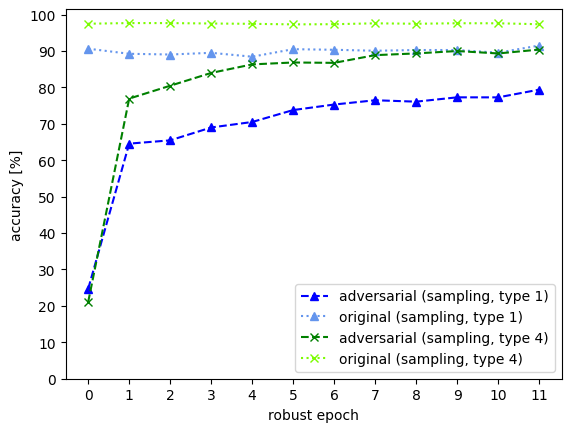

In [7]:
with open(f"{FILEPATH}/saved_graphs/34_robust_values_cheat_recreateTrue_mS5_t4_epoch25_majority_mnist05.pickle", "rb") as file:
    rob_4 = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/34_test_values_cheat_recreateTrue_mS5_t4_epoch25_majority_mnist05.pickle", "rb") as file:
    test_4 = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/23_robust_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    rob_mnist05 = pickle.load(file)
with open(f"{FILEPATH}/saved_graphs/23_test_values_cheat_recreateTrue_mS5_epoch25_majority.pickle", "rb") as file:
    test_mnist05 = pickle.load(file)
n_robust_epoch = 12

x = np.arange(0, 12, dtype=int)
y = np.arange(0, 101, 10, dtype=int)

plt.plot(x, rob_mnist05[:n_robust_epoch], "^--", color="blue", label="adversarial (sampling, type 1)")
plt.plot(x, test_mnist05[:n_robust_epoch], "^:", color="cornflowerblue", label="original (sampling, type 1)")

plt.plot(x, rob_4, "x--", color="green", label="adversarial (sampling, type 4)")
plt.plot(x, test_4, "x:", color="lawngreen", label="original (sampling, type 4)")

plt.xticks(x)
plt.yticks(y)
plt.xlabel("robust epoch")
plt.ylabel("accuracy [%]")

plt.legend()

plt.savefig(f"{FILEPATH}/saved_imgs_thesis/appendix/robloop_type4.pdf", bbox_inches="tight")

plt.show()



## END

---